`PART A: EDA, DATA CLEANING and DATA PREPROCESSING:`

# **1.Overview:**

## **Introduction:** <br>
Global warming is not an issue anymore, rather it’s a situation. Since the buildings plays key role in energy utilization and co2 emissions, bringing efficiency in Energy Consumption is the most practical way to counter the climate change. Various initiatives such as Pay -For- Performance are taken in order to encourage building owners and investors to invest in energy efficient buildings by metering energy savings and getting return-of-investment based on proven and measured savings in the buildings (performance). 
With the goal of attracting large scale investors and financial institutions for enabling progress in building efficiencies, American Society of Heating and Air-Conditioning Engineers (ASHRAE), founded in 1894, launched the Kaggle competition to build the machine learning model which can estimate the energy consumptions of the buildings based on their historical data. 
 


## **Business Problem:**
<br>To implement the aforementioned scheme i.e. Pay -For- Performance, engineering models are required to build which can accurately predict the future energy consumption based on the historical data. The total energy saving is calculated as a difference between predicted and actual energy consumptions after retrofit.

The predicted value would indicate how much energy would have been consumed by any particular building without implementing energy efficiency measures and facilitate the process of computing how much energy has been saved after implementing energy efficiency measures.

## **ML formulation of business problem:** 
<br> ASHRAE has provided metered energy consumption data four different types of meters i.e. Chilled Water, Electric, Hot Water and Steam meters along with the building and weather data. The data is from 16 unique sites and over 1000 buildings over the period of three years.  
The main problem we are solving is to predict energy meter readings based on the given data. So, the target variable is meter readings. Since the meter readings can takes up any real value i.e. Continuous Dependent Variables, we will treat this problem as a regression problem. 


# **2. First Cut Approach:**

1.	After gathering all the relevant data for this case study, first thing I would like to work on is to understand the data and all the features thoroughly. This includes EDA, data cleaning and pre-processing. I will look for any anomalies in the given data which includes duplicates datapoints, missing values, data unit conversion etc. EDA will help to understand distribution of features across the dataset, their relationship with the target variable and outlier detection. Data cleaning includes outlier treatment, missing data imputation, dropping irrelevant features, data unit conversion if required, data scaling etc.
2.	After data pre-processing, Next step will be feature selection and feature engineering. In order to determine which feature is important, I would like to use techniques like correlation graph and Shapley value. We have weather data and timestamps are available in the data. We know that the weather has significant impact on energy utilization and there are many new features we can compute using the weather data such as humidity.
3.	Data splitting: As the timestamp information is available, time-based splitting is preferable method, however in order to capture all the energy utilization pattern, I will include every three-month data in a training dataset followed by next month data as a test dataset.
4.	Model selection: In order to set benchmarking performance, I will train any simple model such as linear regression as a baseline model. Many case studies indicate that models such as K-NN and SVM with RBF kernels can be used as a predictive model with significant accuracy. The decision tree-based algorithms such as decision tree, RF, GBDT, CatBoost and LightGBM performs very well in predictive task. Also, deep learning algorithms such as ANN can be used as a predictive model. So, I will try all these algorithms to solve our problem statement.
5.	Model Evaluation: There are many evaluation metrics can be used to evaluate the performance of the regression model. ASHRAE guidelines suggest that CV(RSME) can be used in the energy prediction problems. Also, in the Kaggle competition, prescribed evaluation metrics was RMSLE. Also, RMSE is also very good option as it indicates how large the residuals being dispersed. So, combination of all these metrics might be helpful to evaluate our models,
6.	Amongst all the models mentioned above, Hyperparameter tuning can be done on the best performing model, using techniques like Random Search CV and Grid Search to finetune the model further to improve the performance.
7.	Prediction: Target values of the test data will be predicted using fine-tuned model and will be uploaded to Kaggle website to get the leader board score. 


# **3.Importing Dependencies and Required Functions:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras import models
import tensorflow.keras.backend as K
from sklearn.impute import SimpleImputer 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
#Reference:https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
import pandas as pd
import numpy as np
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# **4.Building Metadata:**

It contains information about,
* **Unique Sites:** [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
* **Total Buildings**: 1449
* **Total Buildings categories by usage**: 16.

The dataset has following features:

*	`site_id`: It contains information about building locations. There are total 16 unique sites.
*	`building_id`: It contains information about unique buildings. The dataset contains information about total 1449 unique buildings from 16 sites.
*	`primary_use`: This feature tells about purpose of the building being used. There are total 16 unique types of buildings.
*	`square_feet`: Total built-up area of the building.
*	`year_built`: The year on which the construction of the building is completed.
*	`floor_count`: Total number of floors in the particular building.



#### **4.1 Loading Data:**

In [ ]:
building_metadata = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/building_metadata.csv')
building_metadata = reduce_mem_usage(building_metadata)
building_metadata.head(5)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

### **4.2 EDA with Building Metadata:**

#### **4.2.1 Info:**

In [ ]:
print("Unique Sites    :",building_metadata.site_id.unique().tolist())
print("Total Buildings : ",len(building_metadata.building_id.unique().tolist()))

print("Total Buildings categories by usage : ",len(building_metadata.primary_use.unique().tolist()))


Unique Sites    : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Total Buildings :  1449
Total Buildings categories by usage :  16


In [ ]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   site_id      1449 non-null   int8    
 1   building_id  1449 non-null   int16   
 2   primary_use  1449 non-null   category
 3   square_feet  1449 non-null   int32   
 4   year_built   675 non-null    float16 
 5   floor_count  355 non-null    float16 
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.9 KB


**Observations:**
* It is observed that missing values are present in the year_built and floor_count features.

In [ ]:
pd.isna(building_metadata.floor_count)

0       True
1       True
2       True
3       True
4       True
        ... 
1444    True
1445    True
1446    True
1447    True
1448    True
Name: floor_count, Length: 1449, dtype: bool

#### **4.2.2 Floor Count:**

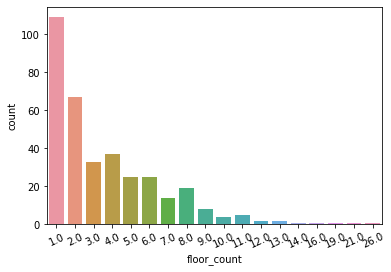

In [ ]:
sns.countplot(building_metadata.floor_count)
plt.xticks(rotation = 25)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [ ]:
building_metadata.floor_count.dropna().quantile(0.90)

8.0

**Observations:**
* 90% of the buildings in the texr dataset have the floor counts < = 8 and the max number of floors any building has is 26.

#### **4.2.3 Distribution on buildings over sites:**

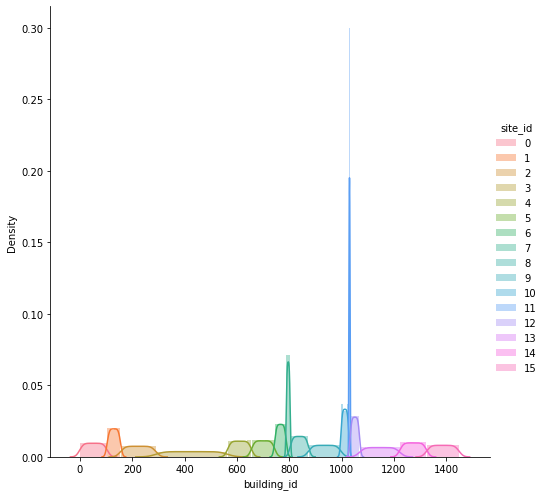

In [ ]:
sns.FacetGrid(building_metadata, hue = 'site_id', height=7).map(sns.distplot, 'building_id').add_legend()
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [ ]:
building_metadata[building_metadata.site_id==11]

site_id  building_id primary_use  square_feet  year_built  floor_count
1028       11         1028   Education        81390         NaN          NaN
1029       11         1029   Education       152559         NaN          NaN
1030       11         1030   Education        68030         NaN          NaN
1031       11         1031   Education        93206         NaN          NaN
1032       11         1032   Education       127632         NaN          NaN

**Observations:**
* This shows that we have information about ony 5 buildings from site 11 and all are related to education.

#### **4.2.4 Distribution of buildings over sites:**

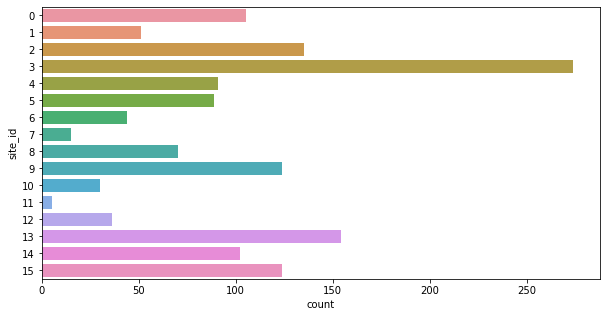

In [ ]:
sns.countplot(y=building_metadata.site_id)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

**Observations:**
* This shows that highest number of the buildings are located at site 03.

#### **4.2.5 Primary Use:**

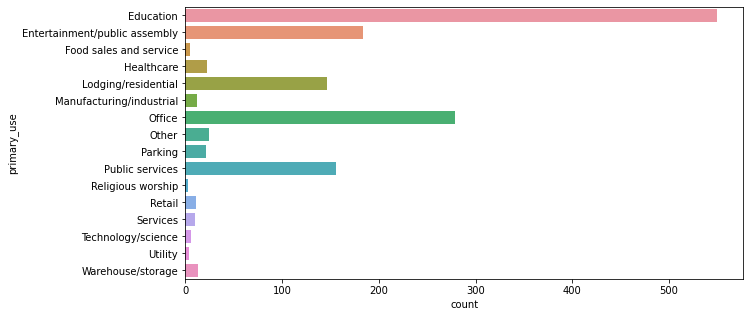

In [ ]:
sns.countplot(y=building_metadata.primary_use)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

**Observations:**
* This indicated that the most of the data recorded from an educational institutions. In the educational buildings or other commercial spaces, since not everyone has an access to the electrical systems, it is expected to see much stable patterns on energy consumptions as compared to those datapoints from Residential/Lodging Space where an individual traits can impact the energy consumption. 

**It might be useful to build seperate models for lodging/residential blocks**

#### **4.2.6 Square Feet Data:**

In [ ]:
print(building_metadata.square_feet.describe())
print("\nMin Square feet = {0}, \nMax Square Feet ={1}.".format(building_metadata.square_feet.min(), building_metadata.square_feet.max()))

count      1449.000000
mean      92111.776398
std      110769.950997
min         283.000000
25%       23012.000000
50%       57673.000000
75%      115676.000000
max      875000.000000
Name: square_feet, dtype: float64

Min Square feet = 283, 
Max Square Feet =875000.


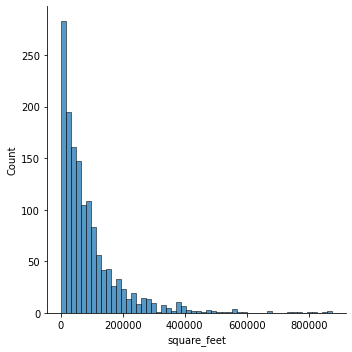

In [ ]:
sns.displot(building_metadata.square_feet)
#plt.xticks([i for i in range(0,building_metadata.square_feet.max())])
plt.rcParams["figure.figsize"] = (11,5)
plt.show()

**Observations:**
* It seems like buildings build up area follows **Power-Law Distribution**.

 #### **4.2.7 Year Build:**

In [ ]:
percnt = np.round((building_metadata.year_built.isna().sum()/len(building_metadata))*100, 2)
print("Total missing values from feature year_built are {0}, i.e. {1}% :".format(building_metadata.year_built.isna().sum(), percnt))

Total missing values from feature year_built are 774, i.e. 53.42% :


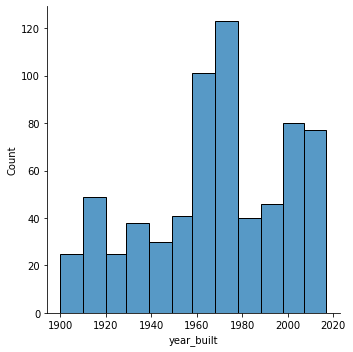

In [ ]:
sns.displot(building_metadata.year_built)
#plt.xticks([i for i in range(0,building_metadata.square_feet.max())])
plt.rcParams["figure.figsize"] = (11,5)
plt.show()

**Observations:**
* The data shows max number of buildings are built during 1970-80.

### **4.3 Feature Engineering With Building Metadata:**

In [ ]:
percnt = np.round((building_metadata.floor_count.isna().sum()/len(building_metadata))*100, 2)
print("Total missing values from feature floor_count are {0}, i.e. {1}% :".format(building_metadata.floor_count.isna().sum(), percnt))

Total missing values from feature floor_count are 1094, i.e. 75.5% :


**Observations:**
- Since the floor_count information is mostly unavailable, this can be because of various reasons. This might be because this information is not useful or difficult to collect due to security reasons. Let's create the feature if the floor information is available or not and see if this adds any value to our model predictions.
- Also, Since the missing values contributes more than 75%, lets drop the original feature i.e. floor_count.

In [ ]:
floor_info = pd.DataFrame(building_metadata.floor_count.fillna(0))
building_metadata['floor_info'] = floor_info
building_metadata['floor_info'] = building_metadata.floor_info.apply(lambda x: 1 if x!=0 else 0)
#building_metadata = building_metadata.drop(['floor_count'], axis=1)

In [ ]:
building_metadata.floor_info.value_counts()

0    1094
1     355
Name: floor_info, dtype: int64

In [ ]:
building_metadata.head()

site_id  building_id primary_use  ...  year_built  floor_count  floor_info
0        0            0   Education  ...      2008.0          NaN           0
1        0            1   Education  ...      2004.0          NaN           0
2        0            2   Education  ...      1991.0          NaN           0
3        0            3   Education  ...      2002.0          NaN           0
4        0            4   Education  ...      1975.0          NaN           0

[5 rows x 7 columns]

**Summary**
<br>So I have added new feature **floor_info** where 0 represents floor info is unavailalbe and 1 means its available.

_____________________________

# **5. Weather Dataset:**
This dataset describes the weather conditions at the instance when the meter readings are recorded. It has following features:

*	`site_id`: It contains information about building locations. There are total 16 unique sites.
*	`timestamp`: Instance of time when the data is recorded. We can use this information to extract many other features such as year, month, date, day and hour etc. We can use this information to create the new features such as seasons.
*	`air_temperature`: Atmospheric temperature in degree Celsius.
*	`cloud_coverage`: The measure of the cloudiness. It refers to the fraction of the sky obscured by clouds when observed from a particular location.
*	`dew_temperature`: It is the temperature to which air must be cooled for water vapour in it to condense.
*	`precip_depth_1_hr`: It indicates to what depth liquid precipitation would cover a horizontal surface in an observation period if nothing could drain, evaporate or percolate from this surface. The precipitation depth of 1 mm corresponds to a liquid quantity of 1 liter to 1 m² of ground area.
*	`sea_level_pressure`: It is a measure of reduced pressure under observed conditions which removes the effect of elevation from the pressure readings.
*	`wind_direction`: It indicates from where the wind is blowing.
*	`wind_speed`: It describes how fast the air is moving past a certain point.


### **5.1 Loading Data:**

In [ ]:
weather_train = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/weather_train.csv')
weather_train = reduce_mem_usage(weather_train)
weather_train.head(-5)

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


site_id            timestamp  ...  wind_direction  wind_speed
0             0  2016-01-01 00:00:00  ...             0.0    0.000000
1             0  2016-01-01 01:00:00  ...            70.0    1.500000
2             0  2016-01-01 02:00:00  ...             0.0    0.000000
3             0  2016-01-01 03:00:00  ...             0.0    0.000000
4             0  2016-01-01 04:00:00  ...           250.0    2.599609
...         ...                  ...  ...             ...         ...
139763       15  2016-12-31 14:00:00  ...           170.0    5.699219
139764       15  2016-12-31 15:00:00  ...           160.0    6.699219
139765       15  2016-12-31 16:00:00  ...           170.0    7.199219
139766       15  2016-12-31 17:00:00  ...           180.0    7.699219
139767       15  2016-12-31 18:00:00  ...           180.0    8.203125

[139768 rows x 9 columns]

### **5.2 Dealing with timestamps**

Since the weather conditions has direct impact on the energy consumption, and it varies greately with the seasons, Let's extract this information from the timestamps available in this Dataset. <br>
*Reference: https://www.marsja.se/pandas-convert-column-to-datetime/* <br>
*Reference: https://towardsdatascience.com/extracting-features-from-dates-fbb7f19972fd*

#### **5.2.1 Extracting info. from timestamps.** 

In [ ]:
import datetime as dt
weather_train['timestamp_'] = pd.to_datetime(weather_train['timestamp'])

In [ ]:
weather_train['year'] = weather_train['timestamp_'].dt.year
weather_train['month'] = weather_train['timestamp_'].dt.month
weather_train['day_of_Week'] = weather_train['timestamp_'].dt.dayofweek
weather_train['day_name'] = weather_train['timestamp_'].dt.day_name()
weather_train['hour'] = weather_train['timestamp_'].dt.hour

In [ ]:
weather_train[['timestamp', 'year', 'month','day_of_Week', 'day_name', 'hour']].head()

timestamp  year  month  day_of_Week day_name  hour
0  2016-01-01 00:00:00  2016      1            4   Friday     0
1  2016-01-01 01:00:00  2016      1            4   Friday     1
2  2016-01-01 02:00:00  2016      1            4   Friday     2
3  2016-01-01 03:00:00  2016      1            4   Friday     3
4  2016-01-01 04:00:00  2016      1            4   Friday     4

**Observations:**
* Adding day_name feature may be useful as the energy consumptions of the commercial buildings during weekends and holidays are less whereas that of residential buildings are on higher side.

#### **5.2.2 Adding Season Feature:**
Energy consumptions is also depends on the season of the year. In the USA, there are 4 seasons.
- **Summer** : June - August (6,7,8)            -->3
- **Fall**   : September - November (9,10,11)   -->4
- **Winter** : December - February (12,1,2)     -->1
- **Spring** : March - May (3,4,5)              -->2

In [ ]:
#https://stackoverflow.com/questions/44124436/python-datetime-to-season

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

def season(month):
    for month_table in seasons.keys():
        if month in list(month_table):
            return seasons[month_table]
    
weather_train['season'] = weather_train.month.apply(season)

In [ ]:
weather_train[['month','season']][5545:5550]

month  season
5545      8       3
5546      8       3
5547      8       3
5548      8       3
5549      8       3

### **5.3 EDA with Weather Data:**

#### **5.3.1 Info.**

In [ ]:
print(weather_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  category      
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
 9   timestamp_          139773 non-null  datetime64[ns]
 10  year                139773 non-null  int64         
 11  month               139773 non-null  int64         
 12  day_of_Week         139773 non-null  int64         
 13  day_name            139773 no

**Observations:**
* The Feature timestamp is of object type.
* The features cloud_coverage, dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction and wind_speed contains NAN values.

#### **5.3.2 Air Temprature**

In [ ]:
weather_train.air_temperature.describe()

count    139718.000000
mean               NaN
std           0.000000
min         -28.906250
25%           7.199219
50%          15.000000
75%          22.203125
max          47.187500
Name: air_temperature, dtype: float64

Maximum and Minimum temp recorded are 47.1875 and -28.90625 respectively
--------------------------------------------------


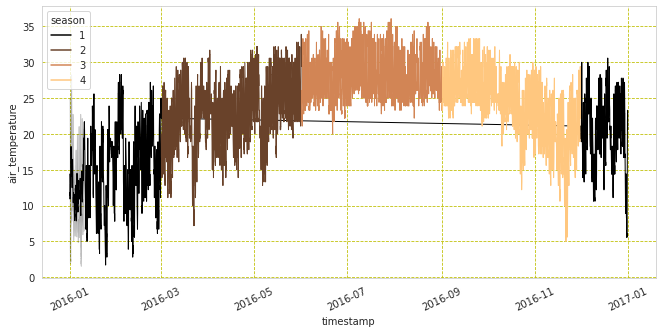

In [ ]:
print("Maximum and Minimum temp recorded are {0} and {1} respectively"\
      .format(weather_train.air_temperature.max(),weather_train.air_temperature.min()))
print("--"*25)

#Sampling few datapoints for better visualization 
weather_train_sample = weather_train[0:9000]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=weather_train_sample.timestamp, y=weather_train_sample.air_temperature, 
             markers='d', hue=weather_train.season, palette='copper',
              linewidth=1)

plt.xticks(rotation = 25)
plt.rcParams["figure.figsize"] = (14,5)
plt.show()

**Observations:**
* Season 3 - represents summer, the air temperature is on higher sides as compared to other seasons.

#### **5.3.3 Dew Temprature**

Maximum and Minimum temp recorded are 26.09375 and -35.0 respectively
--------------------------------------------------


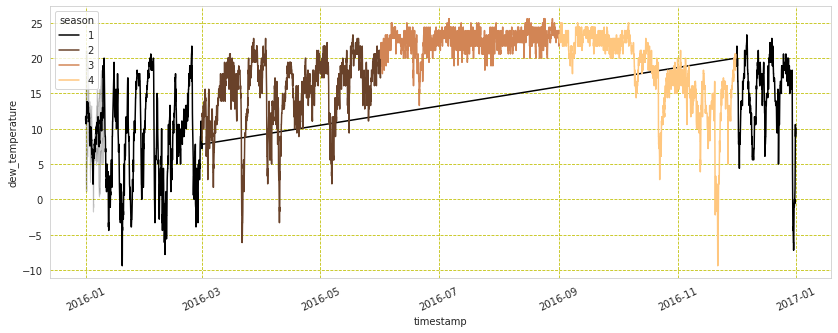

In [ ]:
print("Maximum and Minimum temp recorded are {0} and {1} respectively"\
      .format(weather_train.dew_temperature.max(),weather_train.dew_temperature.min()))
print("--"*25)

#Sampling few datapoints for better visualization 
weather_train_sample = weather_train[0:9000]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=weather_train_sample.timestamp, y=weather_train_sample.dew_temperature, 
             markers='d', hue=weather_train.season, palette='copper',
              linewidth=1.5)

plt.xticks(rotation = 25)
plt.rcParams["figure.figsize"] = (14,5)
plt.show()

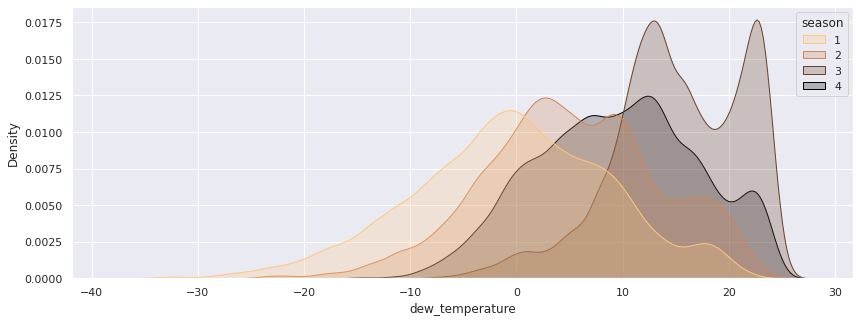

In [ ]:
weather_train_sample = weather_train[0:5000]

sns.set(rc={'figure.figsize':(14,5)})
sns.kdeplot(weather_train.dew_temperature, shade=True, hue=weather_train.season, palette='copper_r')

plt.show()

**Observations:**
* Dew Temperature appears to follow normal distribution for winter, fall and spring season.


#### **5.3.4 Cloud_Coverage**

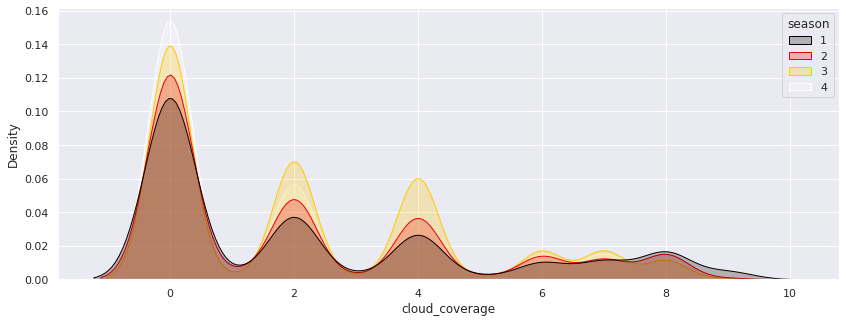

In [ ]:
weather_train_sample = weather_train[0:5000]
sns.set(rc={'figure.figsize':(14,5)})
sns.kdeplot(weather_train.cloud_coverage, shade=True, hue=weather_train.season, palette='hot')

**Observations:**
* Since most of the readings are 0, indicates that sky  mostly appears to be clear throughout all the seasons.

#### **5.3.5 Sea Level Pressure**

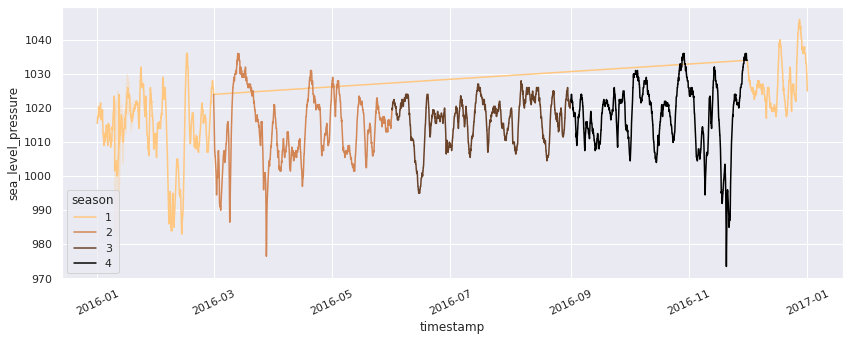

In [ ]:
#Sampling few datapoints for better visualization 
weather_train_sample = weather_train[9000:18000]
sns.set(rc={'figure.figsize':(14,5)})
sns.lineplot(x=weather_train_sample.timestamp, y=weather_train_sample.sea_level_pressure, 
             markers='d', hue=weather_train.season, palette='copper_r',
              linewidth=1.5)
plt.xticks(rotation = 25)
plt.rcParams["figure.figsize"] = (14,8)
plt.show()

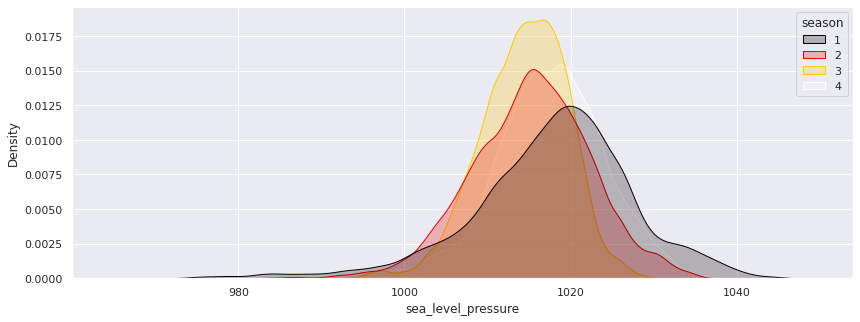

Maximum and Minimum sea level pressure recorded are 1046.0 and 968.0 respectively and appears to follow Gaussian Distribution.
--------------------------------------------------


In [ ]:
weather_train_sample = weather_train[9000:18000]

sns.set(rc={'figure.figsize':(14,5)})
sns.kdeplot(weather_train.sea_level_pressure, shade=True, hue=weather_train.season, palette='hot')
plt.show()

print("Maximum and Minimum sea level pressure recorded are {0} and {1} respectively and appears to follow Gaussian Distribution."\
      .format(weather_train.sea_level_pressure.max(),weather_train.sea_level_pressure.min()))
print("--"*25)

**Observations:**
* Maximum and Minimum sea level pressure recorded are 1046.0 and 968.0 respectively and appears to follow Gaussian Distribution.

#### **5.3.6 Wind Speed and Direction:**

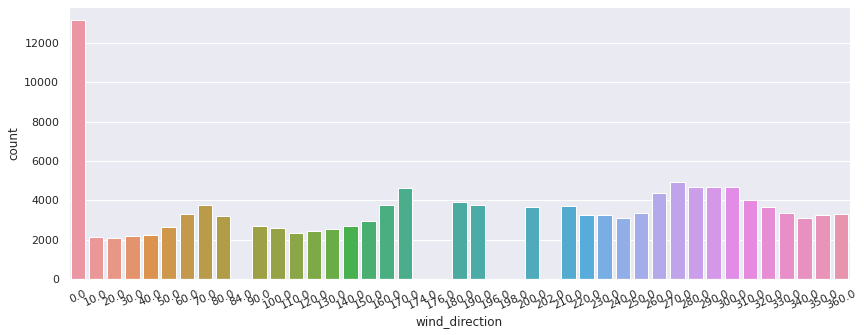

In [ ]:
sns.countplot(x=weather_train.wind_direction)
plt.xticks(rotation = 25)
plt.rcParams["figure.figsize"] = (14,5)
plt.show()

**Monthwise Averge Speed:**

Text(0.5, 1.0, 'Months wise Avg. Wind Speed')

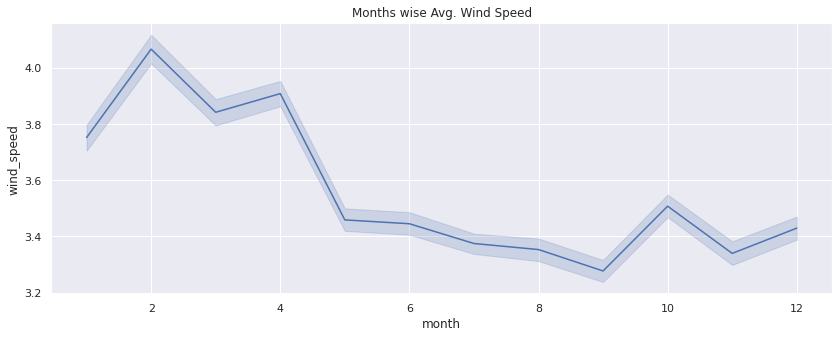

In [ ]:
avg_windspeed = weather_train[['month', 'wind_speed', 'season']]
avg_windspeed.groupby(['month']).aggregate('mean').reset_index()

sns.set(rc={'figure.figsize':(14,5)})
sns.lineplot(x=avg_windspeed.month, y=avg_windspeed.wind_speed)
plt.title("Months wise Avg. Wind Speed")

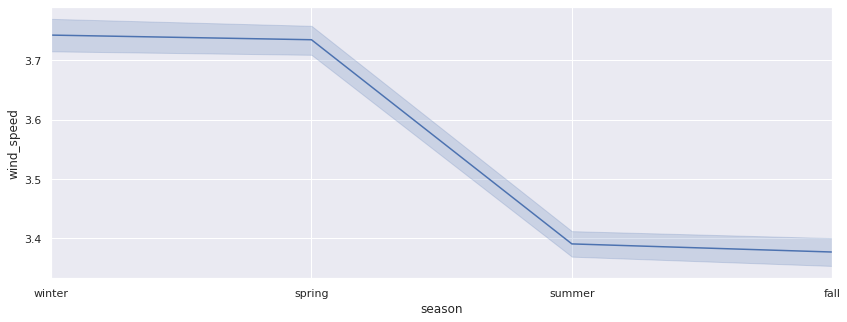

In [ ]:
avg_windspeed = weather_train[['wind_speed', 'season']]
avg_windspeed.groupby(['season']).aggregate('mean').reset_index()

fig,ax = plt.subplots(figsize=(14,5))
sns.lineplot(x=avg_windspeed.season, y=avg_windspeed.wind_speed)
ax.set(xlim=(1,4))
plt.xticks([1,2,3,4]),
labels=['winter','spring','summer','fall']

ax.set_xticklabels(labels)
plt.show()

**Observations:**
* As we can see from the above graph that average windspeed is high during winter and reduces gradually until fall.

### **5.4 Feature Engineering with Weather Data:**

#### **5.4.1 Actual vapour pressure (Ea) derived from dewpoint temperature.**

As the dewpoint temperature is the temperature to which the air needs to be cooled to make the air saturated, the actual vapour pressure (ea) is the saturation vapour pressure at the dewpoint temperature (Tdew) [°C].<br>
Reference:http://www.fao.org/3/x0490e/x0490e07.htm#wind%20speed

In [ ]:
def compute_Ea(df):
  Ea = 0.608 * math.exp((17.27*df.dew_temperature)/(df.dew_temperature+237.3))
  return Ea


In [ ]:
weather_train['Ea'] = weather_train.apply(lambda df:compute_Ea(df), axis=1)

#### **5.4.2 Mean saturation vapour pressure (Es):**

As saturation vapour pressure is related to air temperature, it can be calculated from the air temperature

In [ ]:
def compute_Es(df):
  Es = 0.608 * math.exp((17.27*df.air_temperature)/(df.air_temperature+237.3))
  return Es

In [ ]:
weather_train['Es'] = weather_train.apply(lambda df:compute_Es(df), axis=1)

#### **5.4.3 Relative Humidity:**
Relative humidity is a way of describing how much humidity is present in the air, compared to how much there could be. Meteorologists often use the relative humidity as a measurement to describe the weather at various places.<br>

When the temperature is warm, more water vapor can be in the air than when it is cold. If the actual amount of vapor is compared to the total amount there could be as a fraction, then the number tells if the air feels dry or moist. The value is usually written in percent, where 0% means that the air is totally dry, and 100% means that it is so moist that mist or dew is about to form.<br>
Reference:https://simple.wikipedia.org/wiki/Relative_humidity

Function to compute RH:

In [ ]:
def compute_Rh(df):
  Ea = 0.608 * math.exp((17.27*df.dew_temperature)/(df.dew_temperature+237.3))
  Es = 0.608 * math.exp((17.27*df.air_temperature)/(df.air_temperature+237.3))
  RH = np.round((Ea/Es)*100,2)
  return RH


In [ ]:
weather_train['RH'] = weather_train.apply(lambda df:compute_Rh(df), axis=1)

#### **5.4.4 Cloud Base**
A cloud base (or the base of the cloud) is the lowest altitude of the visible portion of a cloud. It is traditionally expressed either in metres or feet above mean sea level or above a planetary surface, or as the pressure level corresponding to this altitude in hectopascals (hPa, equivalent to the millibar).
Reference:https://en.wikipedia.org/wiki/Cloud_base

Formula:
**Cloud Base**(Meter) = (( **Temperature**(farenheit) - **Dew point**(farenheit) ) / 4.4 ) * 1000 )* 0.3048

In [ ]:
def compute_CB(df):

  Cb = (((((df.air_temperature*1.8)+32) - ((df.dew_temperature*1.8)+32))/4.4)*1000)*0.3048
  Cb = np.round(Cb,2)

  return Cb


In [ ]:
weather_train['Cloud_base'] = weather_train.apply(lambda df:compute_CB(df), axis=1)

#### **5.4.5 Windchill Index (WCI):**

Wind-chill or Windchill is the perceived decrease in air temperature felt by the body on exposed skin due to the flow of air. The effect of wind chill is to increase the rate of heat loss and reduce any warmer objects to the ambient temperature more quickly.

Here is the standard formula that was adopted in 2001 by Canada, UK, and the US to compute and analyze the Wind Chill Index:
- WCI = 13.12 + 0.6215*T – 11.37* v ** 0.16 + 0.3965T* v ** 0.16

    Twc = Wind Chill Index (Based on Celsius temperature scale) <br>
    Ta = Air Temperature (in degree Celsius)<br>
    v = Wind Speed (in miles per hour)<br>
    <br>
- Reference: https://www.geeksforgeeks.org/calculating-wind-chill-factorwcf-wind-chill-indexwci-python/

In [ ]:
def compute_WCI(df):

  WCI = np.round((13.12 + 0.6215 * df.air_temperature - 11.37*((df.wind_speed*2.235)**0.16) \
                  + 0.3965* df.air_temperature * ((df.wind_speed*2.235)**0.16)),2)
  return WCI

In [ ]:
weather_train['WCI'] = weather_train.apply(lambda df: compute_WCI(df), axis=1)

#### **5.4.6 DAY/NIGHT Feature:**
<br> Adding Day Night Feature can be useful as the energy consumptions during day and nights shows different patterns.<br>
In general 06am - 06pm is considered as a day and rest of the hours are considered as night hours. So, we will consider-
- **DAY** - 06-18 hours. 
- **NIGHT** - 19-05 hours.

In [ ]:
day_hours = [i for i in range(6,19)]
weather_train['D/N'] = weather_train.hour.apply(lambda x: 'Day' if x in day_hours else 'Night')

_____________

In [ ]:
print("New Features Are:")
weather_train[['year',	'month',	'day_of_Week',	'day_name',	'season',	'RH',	'Ea',	'Es',	'Cloud_base',	'WCI', 'D/N']]

New Features Are:


year  month  day_of_Week  day_name  ...        Es  Cloud_base    WCI    D/N
0       2016      1            4    Friday  ...  3.153256      623.45  28.66  Night
1       2016      1            4    Friday  ...  3.043440      413.04  26.23  Night
2       2016      1            4    Friday  ...  2.762384      212.36  27.29  Night
3       2016      1            4    Friday  ...  2.489896       62.35  26.23  Night
4       2016      1            4    Friday  ...  2.327562        0.00  20.99  Night
...      ...    ...          ...       ...  ...       ...         ...    ...    ...
139768  2016     12            5  Saturday  ...  0.754293     1371.60  -0.31  Night
139769  2016     12            5  Saturday  ...  0.743694     1458.79  -1.31  Night
139770  2016     12            5  Saturday  ...  0.743694     1246.91  -0.28  Night
139771  2016     12            5  Saturday  ...  0.712484     1109.55  -0.76  Night
139772  2016     12            5  Saturday  ...  0.687478      910.46  -3.05  Night

[139773 rows x 11 columns]

_____________________________________

# **6.Training Data:**
This dataset contains actual meter readings from the buildings recorded for the period of one year i.e. 2016. Along with the features which are described above such as **building_id** and **timestamp**.
<br>This dataset has following new features:
* `meter`: Type of meter. There are four types of meters. 
	    - Chilled Water
  	  - Electric
	    - Steam
  	  - Hot water
* `meter_readings`: This is target variable. It indicates the actual meter reading recorded at given particular timestamp.


#### **6.1 Loading Data:**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/train.csv')
train = reduce_mem_usage(train)
train.head()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

### **6.2 EDA with Train Data:**

Here, the target variable is meter reading. Lets have look at the meter reading.

#### **6.2.1 Meter Types:**

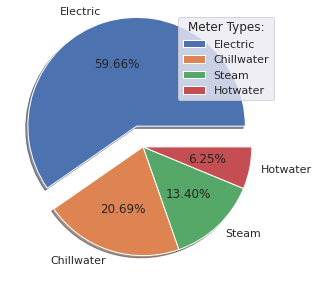

In [ ]:
labels_ = ['Electric','Chillwater','Steam','Hotwater']
explode_ = [0.2, 0, 0, 0]
plt.pie(train.meter.value_counts(), labels= labels_, 
        explode= explode_, shadow = True,  autopct='%2.2f%%')

plt.legend(['Electric','Chillwater','Steam','Hotwater'], title="Meter Types:")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

**Observations:**
* As we can see, around 60% of the readings availabes are from electric meters, while hotwater meter readings are least (6.25%) in the test dataset.

#### **6.2.2 Meter Readings:**

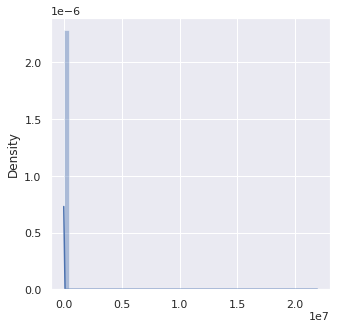

In [ ]:
sns.distplot(x=train.meter_reading)
plt.show()

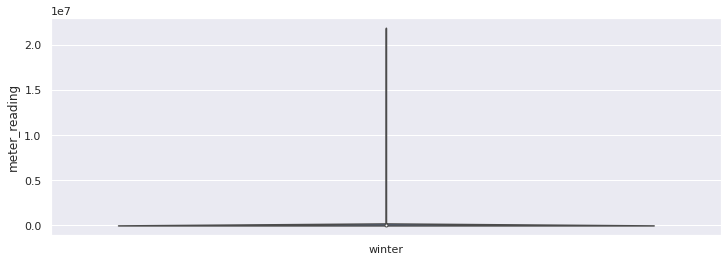

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
sns.violinplot(y=train.meter_reading, hue=train.meter)

ax.set_xticklabels(labels)
plt.show()

**Observations:**
* No conclusion can be drawn seeing distribution of meter reading.
* Looks like it follow **Power-Law Distribution** with **large value of alpha**.

# **7. Combining Dataframes:**

#### **7.1 Let's merge all the dataframes for further analysis with the target variable.**

Merging train and weather_train dataframe.

In [ ]:
print(train.columns)
print(weather_train.columns)
print(building_metadata.columns)

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')
Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')


In [ ]:
data = train.merge(building_metadata, on='building_id', how='left', suffixes=None)

**Merging with weather_train dataframe**

In [ ]:
data = data.merge(weather_train, on=['site_id', 'timestamp'], how='left', suffixes=None)

In [ ]:
data.head(5)

#### **7.2 Saving merged df to CSV:**

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Study 01/Data/train_merged.csv'):
  data.to_csv("/content/drive/MyDrive/Case Study 01/Data/train_merged.csv")
else:
  data = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/train_merged.csv")

#### **7.3 Correction to units for site 0 electric meter**
* Due to a miscommunication, the electric meter readings for site 0 were not 
properly converted to units of kWh and are in kBTU.
* Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring.
* **Reference:** https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

In [ ]:
data[data.site_id==0].meter_reading 

0             0.0000
1             0.0000
2             0.0000
3             0.0000
4             0.0000
              ...   
20213857     84.3644
20213858     33.3021
20213859     39.1790
20213860      0.0000
20213861    273.3650
Name: meter_reading, Length: 1076662, dtype: float64

In [ ]:
data['meter_reading_corrected'] = np.where(np.logical_and(data['site_id'] == 0, data['meter'] == 0),
                                           data['meter_reading'] * 0.2931,
                                           data['meter_reading'])

In [ ]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 4935.57 MB
Memory usage after optimization is: 1273.21 MB
Decreased by 74.2%


#### **7.3 Target Transformation**


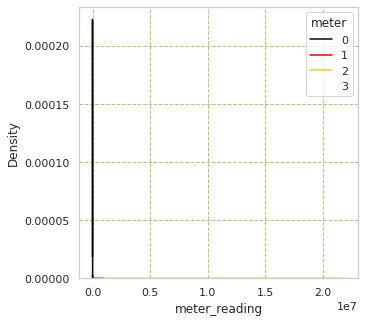

In [ ]:
sns.kdeplot(x=train.meter_reading, hue=train.meter, palette='hot')
plt.show()

**Observations:**
* No conclusion can be drawn seeing distribution of meter reading.
* Looks like it follow **Power-Law Distribution** with **large value of alpha**.
* Lets try Target Transformation as stated https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124709.

In [ ]:
data['meter_reading_transformed'] = np.log1p(data.meter_reading_corrected)
data[['meter_reading', 'meter_reading_corrected', 'meter_reading_transformed']][1111500:1111550].head()

meter_reading  meter_reading_corrected  meter_reading_transformed
1111500      58.950001                58.950001                   4.093511
1111501    2720.770020              2720.770020                   7.909038
1111502     133.417007               133.417007                   4.900947
1111503       0.000000                 0.000000                   0.000000
1111504    1477.449951              1477.449951                   7.298749

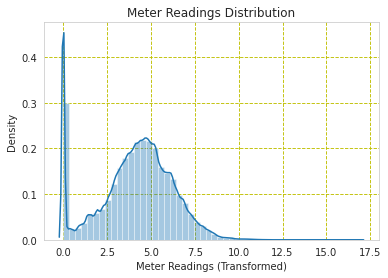

In [ ]:
sns.distplot(x=data.meter_reading_transformed)
plt.xlabel('Meter Readings (Transformed)')
plt.title("Meter Readings Distribution")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.show()

**Observations:**
* After log transformation, It can be seen that meter readings lookes like gaussian distribution with the lots of meter readings = 0.
* There are many zero meter readings in the dataset, which may not be useful for data modeling.

**Let's check distribution of meter readings all meter types seperately.**

100%|██████████| 4/4 [02:48<00:00, 42.16s/it]


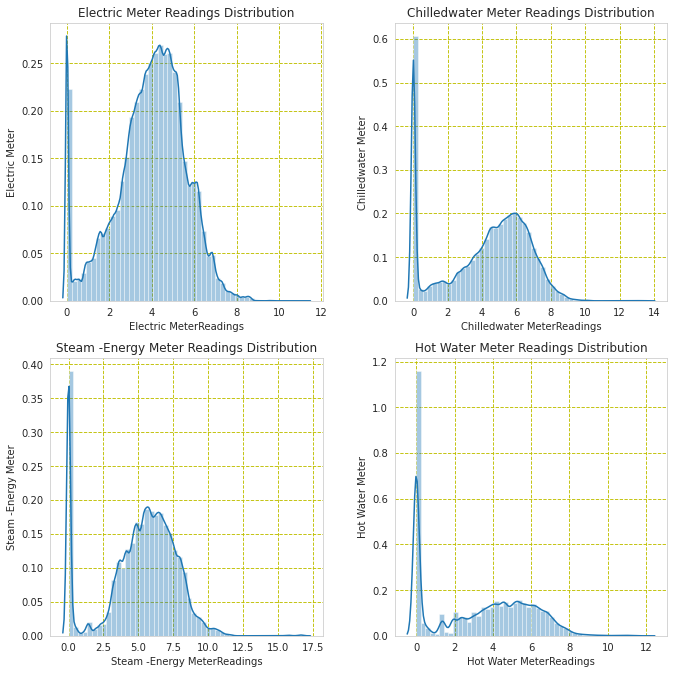

In [ ]:
unique_meters = data.meter.unique().tolist()
meter_names = ["Electric Meter", "Chilledwater Meter", "Steam -Energy Meter", "Hot Water Meter"]

plt.figure(figsize=(10,10))

for i in tqdm(range(len(unique_meters))):
  if i < len(unique_meters):
    plt.subplot(2,2,i+1)
    meter_readings = data[data.meter==i].meter_reading_transformed
    sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
    sns.distplot(meter_readings)
    plt.ylabel(meter_names[i])
    plt.title(meter_names[i] + " Readings Distribution")
    plt.xlabel(meter_names[i] + "Readings")

    plt.grid(color='y', linestyle='--', linewidth=0.9)

plt.tight_layout(pad=3, h_pad=1, w_pad=None, rect=None)
plt.show()

**Observations:**
* All the meter types have almost same types of distributions with lots of zero meter readings. It will be analysed further i the next session ***(section 7.5.5)***.

__________________________

#### **7.4 Meterwise Energy Consumption over one year:**

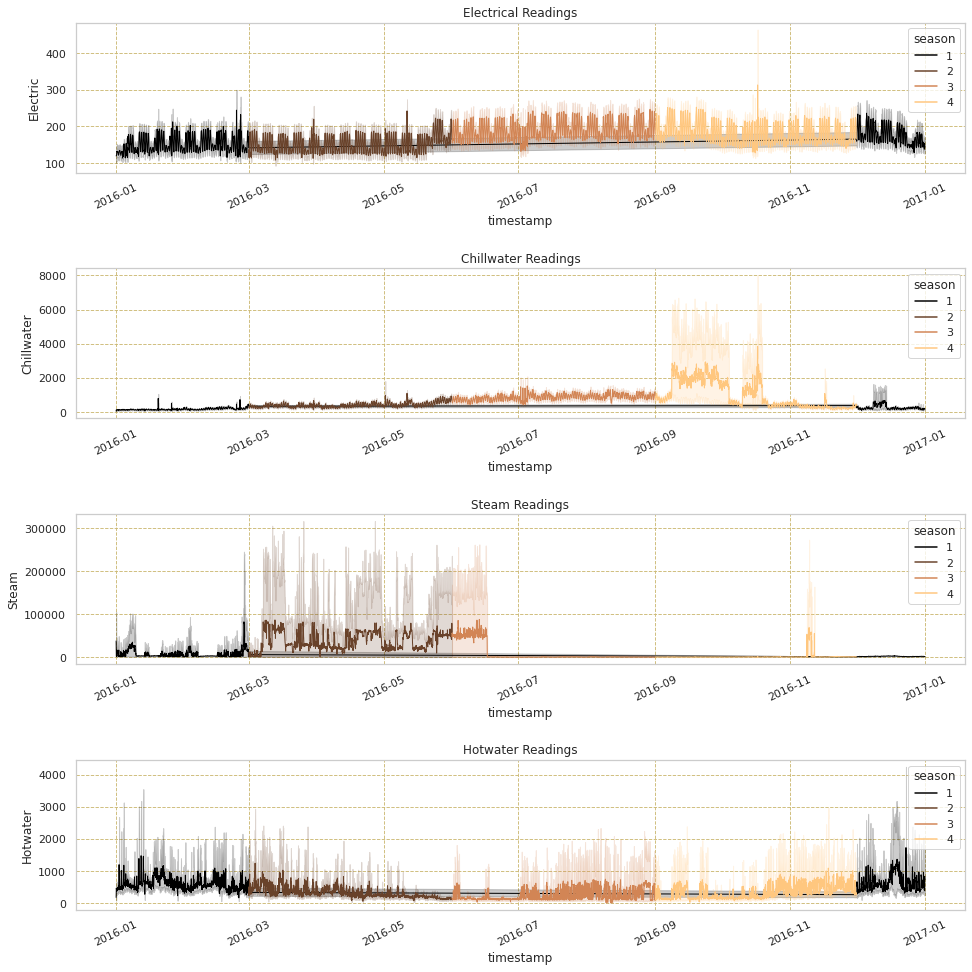

In [ ]:
plt.figure(figsize=(14,14))

plt.subplot(411)
data_electrical = data[data.meter==0][['timestamp', 'meter_reading','season']]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=data_electrical.timestamp, y=data_electrical.meter_reading, 
             markers='d', hue=data_electrical.season, palette='copper',
              linewidth=1)
plt.title("Electrical Readings")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.ylabel("Electric")
plt.xticks(rotation = 25)

plt.subplot(412)
data_Chillwater = data[data.meter==1][['timestamp', 'meter_reading','season']]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=data_Chillwater.timestamp, y=data_Chillwater.meter_reading, 
             markers='d', hue=data_Chillwater.season, palette='copper',
              linewidth=1)
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.title("Chilledwater Readings")
plt.ylabel("Chilledwater")
plt.xticks(rotation = 25)


plt.subplot(413)
data_Steam = data[data.meter==2][['timestamp', 'meter_reading','season']]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=data_Steam.timestamp, y=data_Steam.meter_reading, 
             markers='d', hue=data_Steam.season, palette='copper',
              linewidth=1)
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.title("Steam Readings")
plt.ylabel("Steam")
plt.xticks(rotation = 25)


plt.subplot(414)
data_Hotwater = data[data.meter==3][['timestamp', 'meter_reading','season']]
sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
sns.lineplot(x=data_Hotwater.timestamp, y=data_Hotwater.meter_reading, 
             markers='d', hue=data_Hotwater.season, palette='copper',
              linewidth=1)
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.title("Hotwater Readings")
plt.ylabel("Hotwater")
plt.xticks(rotation = 25)


plt.tight_layout(pad=2.08, h_pad=None, w_pad=None, rect=None)
plt.show()

**Observations:**

We can see different patterns of energy usage based on the seasons.
* In **summer** (season=3) the demand for **electricity** and **chillwater** is relatively **higher** than as compared with other seasons.
* During **winter**, the demand for **Steam** and Hot **water** is **high** as compared to chillwater.

### **7.5 EDA on Merged Dataframe:**

#### **7.5.1 Energy Consumption based on Building Usage and day:**

In [ ]:
print(data.primary_use.unique().to_list())

['Education', 'Lodging/residential', 'Office', 'Entertainment/public assembly', 'Other', 'Retail', 'Parking', 'Public services', 'Warehouse/storage', 'Food sales and service', 'Religious worship', 'Healthcare', 'Utility', 'Technology/science', 'Manufacturing/industrial', 'Services']


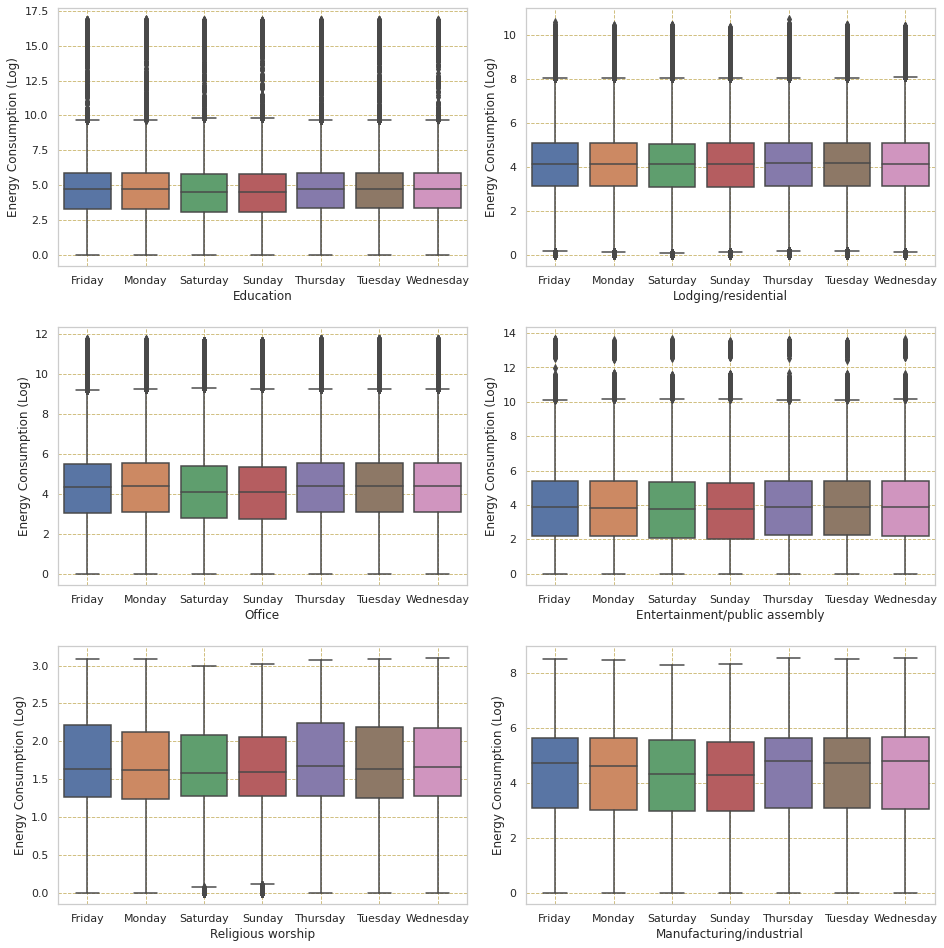

In [ ]:
plt.figure(figsize=(14,14))

plt.subplot(321)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data[data.primary_use=='Education'])
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.ylabel("Energy Consumption (Log)")
plt.xlabel("Education")

plt.subplot(322)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data_sliced[data_sliced.primary_use=='Lodging/residential'])
plt.ylabel("Energy Consumption (Log)")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.xlabel("Lodging/residential")

plt.subplot(323)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data[data.primary_use=='Office'])
plt.ylabel("Energy Consumption (Log)")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.xlabel("Office")

plt.subplot(324)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data[data.primary_use=='Entertainment/public assembly'])
plt.ylabel("Energy Consumption (Log)")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.xlabel("Entertainment/public assembly")

plt.subplot(325)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data[data.primary_use=='Religious worship'])
plt.ylabel("Energy Consumption (Log)")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.xlabel("Religious worship")

plt.subplot(326)
sns.boxplot(x='day_name', y ='meter_reading_transformed',data=data[data.primary_use=='Manufacturing/industrial'])
plt.ylabel("Energy Consumption (Log)")
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.xlabel("Manufacturing/industrial")

plt.tight_layout(pad=3.08, h_pad=2, w_pad=1, rect=None)
plt.show()


**Observations:**

**Day wise energy consumption for few selected building types.**
* We have plotted log of energy consumed by the buildings.
* It can be seen that the Energy Consumption for the sectors such as Religious Worship, Office, manufacturing/industrial, are less on weekends as compared to weekdays.
* Energy Consumptions for residential buildings throughout the week remains same however thisshould not be the case and residential buildings expected to consume relatively more energy on weekends.
* Since there are many pointes lies outsides the whiskers, they probably represents the outliers.

#### **7.5.2 Relationship between WCI and Electric Meter Readings.- Throughout the Year**

100%|██████████| 4/4 [03:04<00:00, 46.04s/it]


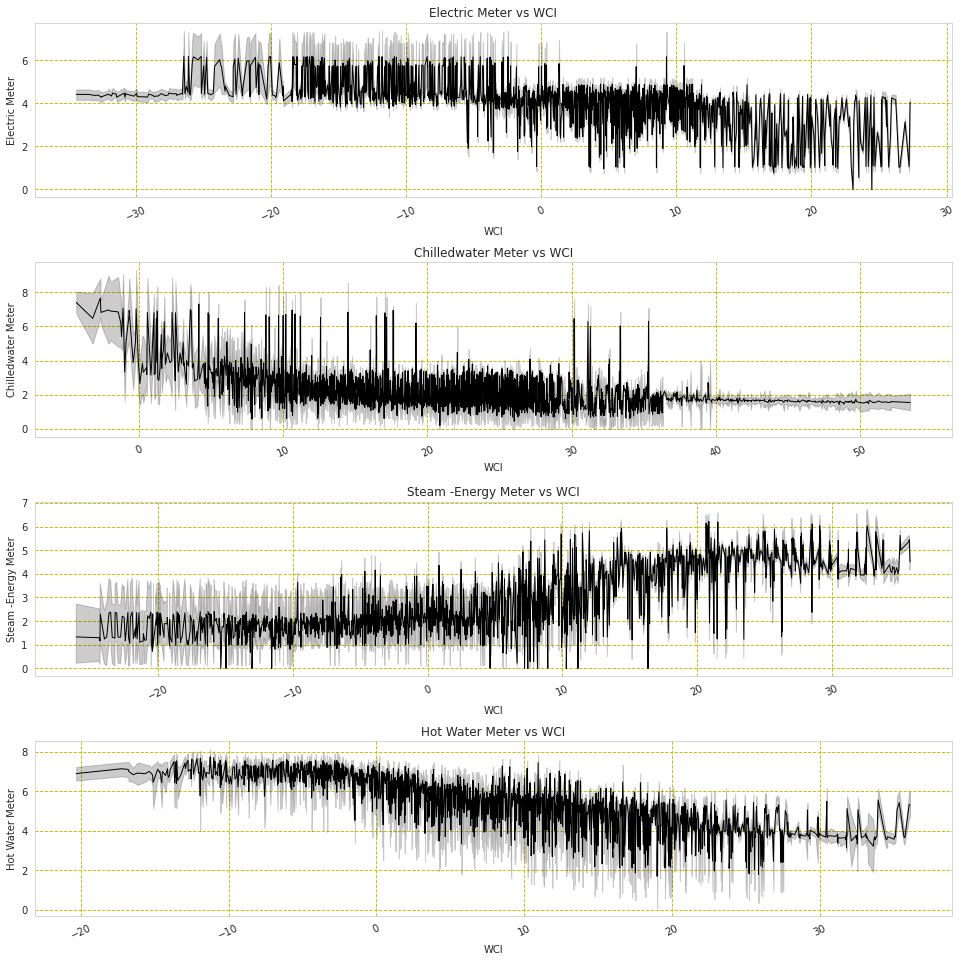

In [ ]:
unique_meters = data.meter.unique().tolist()
meter_names = ["Electric Meter", "Chilledwater Meter", "Steam -Energy Meter", "Hot Water Meter"]

plt.figure(figsize=(14,14))

for i in tqdm(range(len(unique_meters))):
  if i < len(unique_meters):
    plt.subplot(4,1,i+1)
    data_meter = data[data.meter==unique_meters[i]][['WCI', 'meter_reading_transformed','season']]
    data_meter_sample = data_meter[500000:1000000]
    sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
    sns.lineplot(x=data_meter_sample.WCI, y=data_meter_sample.meter_reading_transformed, 
                markers='d', hue=None, color='black',
                  linewidth=1)
    plt.ylabel(meter_names[i])
    plt.title(meter_names[i] + " vs WCI")
    plt.xlabel("WCI")
    #plt.legend(labels=["Winter","Spring","Summer","Fall"]) #Error, should be seasons
    plt.grid(color='y', linestyle='--', linewidth=0.9)
    plt.xticks(rotation = 25)
plt.tight_layout(pad=3, h_pad=1, w_pad=None, rect=None)
plt.show()

**Observations:**
* It can be seen that the **Electrical Consumptions** when wind **chill index** **low**,relatively **high**.
* **Hot Water** usage and **WCI** seems like holding **inverse relationship**.

#### **7.5.3 Meterwise Avg Monthly Usage - All Data**

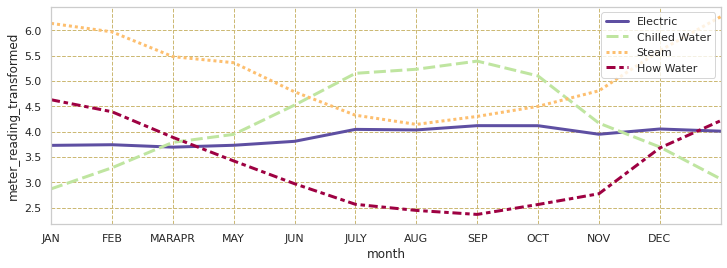

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))

meterwise_df = data.groupby(['month','meter'], as_index=False)[['meter_reading_transformed','meter']].mean()
sns.lineplot(data= meterwise_df, x='month', y='meter_reading_transformed', hue='meter', style="meter", palette='Spectral_r',linewidth=3)

ax.set(xlim=(1,12))
plt.xticks([i for i in range(1,13)]),
labels=['JAN','FEB','MAR' 'APR', 'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ax.set_xticklabels(labels)
plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])
plt.show()

**Observations:**
* It is evident that the Avg Electrical Meter readings doesn't fluctuate much as compared to other meters readings.
* How water readings and Chilled water readings are inversely proportional to each other. 
* During winter, the usage of steam is more as compared with its usage in rest of the year with min value during summer.

#### **7.5.4 Meterwise Seasonal Avg. Usage**

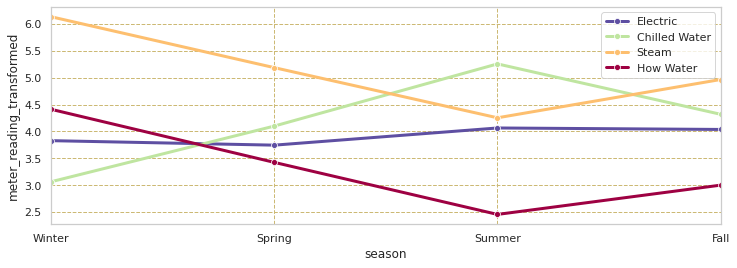

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))

data_electrical_df = data.groupby(['season','meter'], as_index=False)[['meter_reading_transformed','meter']].mean()
sns.lineplot(data= data_electrical_df, x='season', y='meter_reading_transformed', hue='meter',
              palette='Spectral_r',linewidth=3, markers=True, marker="o")
sns.scatterplot(data= data_electrical_df, x='season', y='meter_reading_transformed', marker="*", size=10)

ax.set(xlim=(1,4))
plt.xticks([i for i in range(1,5)]),
labels=['Winter', 'Spring', 'Summer', 'Fall']
ax.set_xticklabels(labels)
plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])
plt.show()

**Observations:**
* It is evidn't that the Avg Electrical Meter readings doesn't fluctuate much as compared to other meters readings.
* How water readings and Chilled water readings are inversely proportional to each other. 
* During winter, the usage of steam is more as compared with its usage in rest of the year with min value during summer.

#### **7.5.5 Sitewise Avg Monthly Usage**

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))

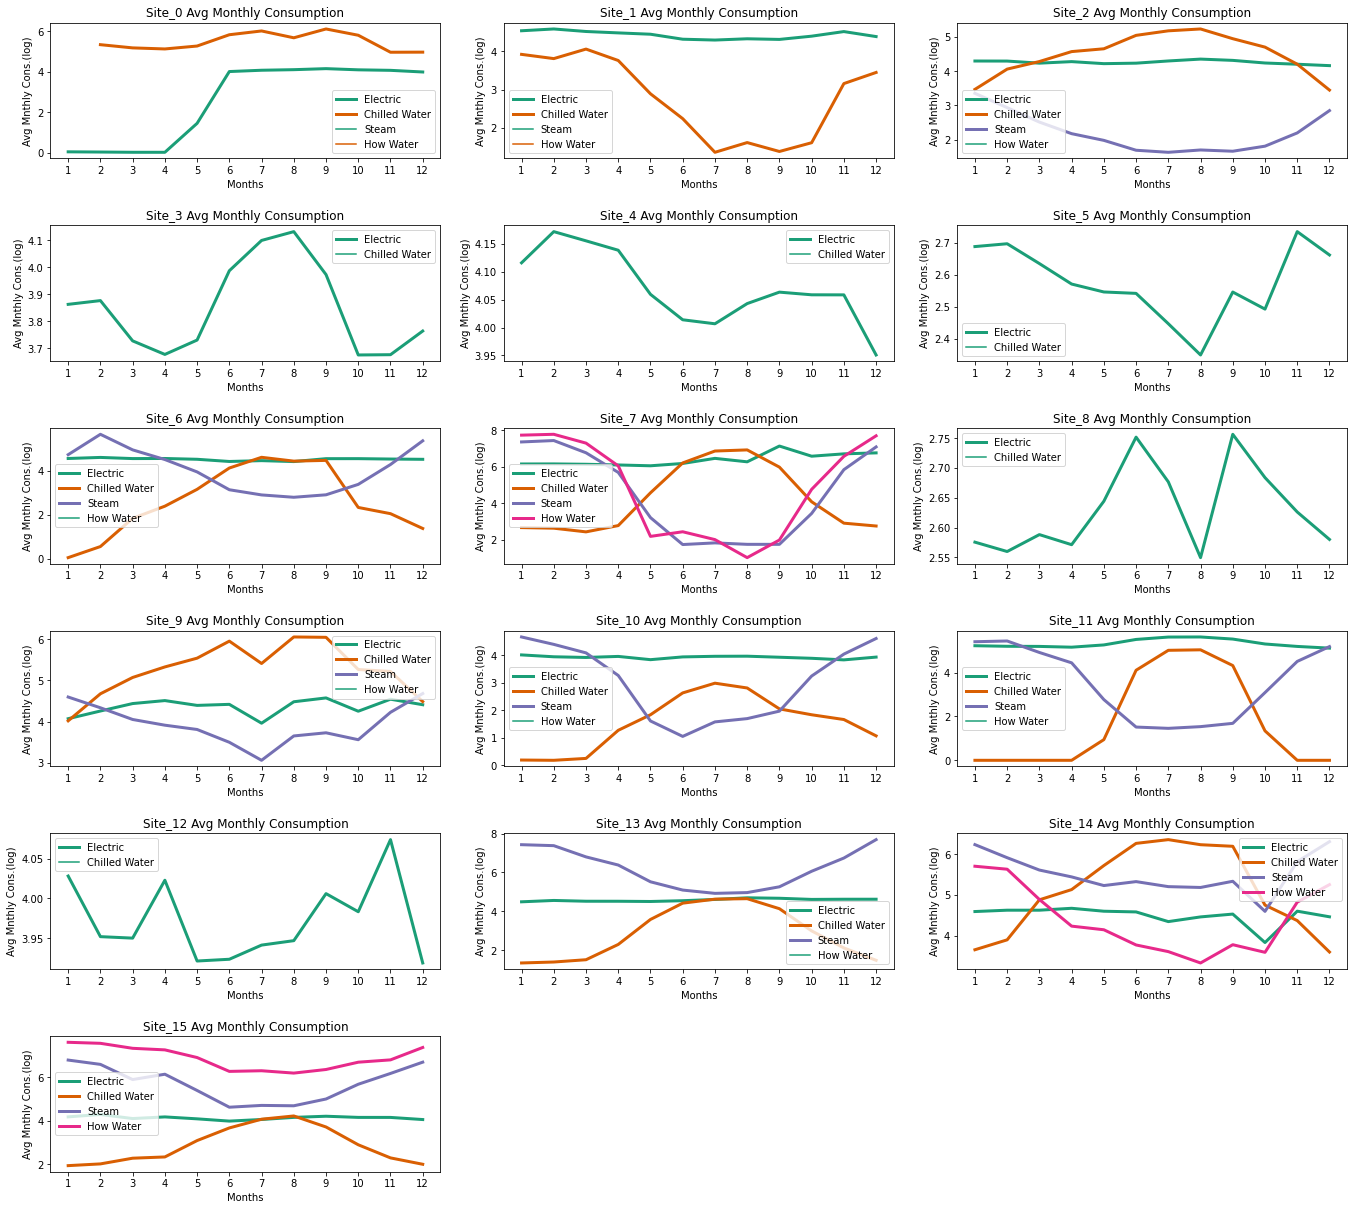

In [ ]:
site_df = data.groupby(['site_id','month', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()
site_ids = site_df.site_id.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(site_ids)+1):
  if i < len(site_ids):

    plt.subplot(6,3,i+1)

    sns.lineplot(data= site_df[site_df.site_id==site_ids[i]], x='month', y='meter_reading_transformed', 
                 hue='meter', palette='Dark2',linewidth=3)
    ax.set(xlim=(1,12))
    plt.xticks([i for i in range(1,13)]),
    plt.title("Site_" + str(site_ids[i])+ " Avg Monthly Consumption")
    plt.xlabel("Months")
    plt.ylabel("Avg Mnthly Cons.(log)")
    plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()

**Observations:**
* It seems that not all sites have all types of meters.
* **site_0** -There are some **anamolies** in electric meter readings for **initial months.** ***(Refer section 8.1.2 for further analysis)***
* For site_1, site_2, site_6, site_10, site_11, site_13 and site_15 the  average monthly electrical consumptions doesn't fluctuate much throughout the year where as for site_3, site_4, site_5, site_8 and site_12, it varies according to months.
* Chilled water consumption during summer months is high as compared to rest of the seasons, on contrary Steam water utilization shows exactly opposite curve.

#### **7.5.6 Sitewise Avg Weekly Usage**

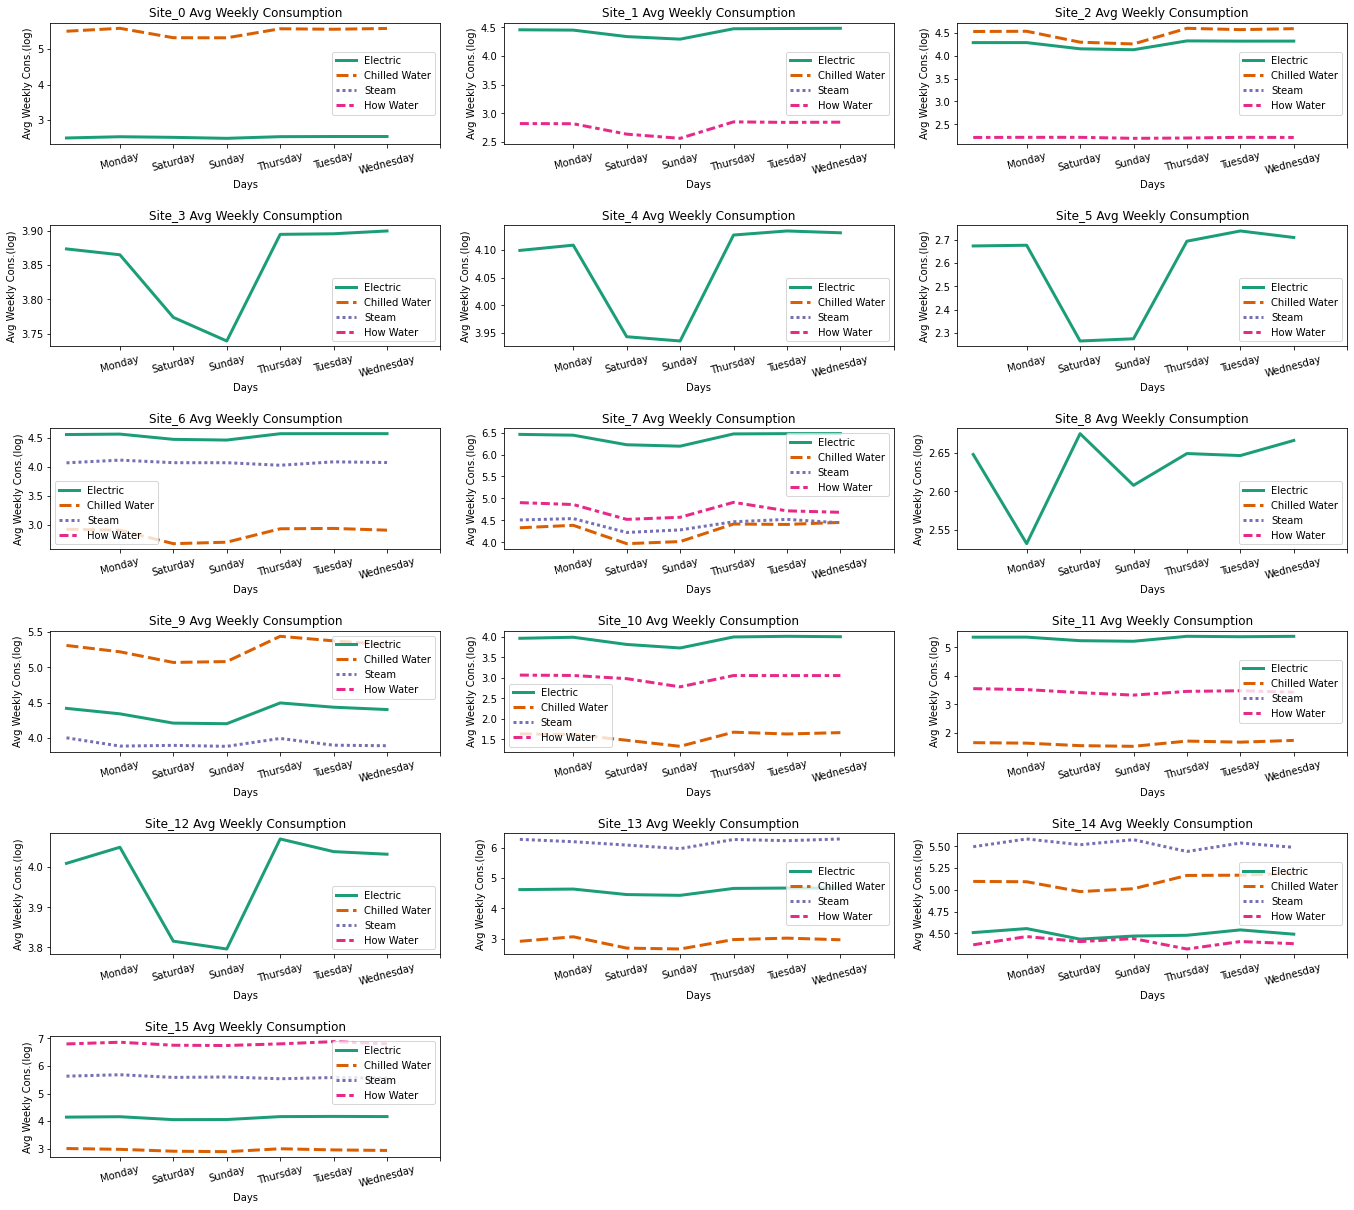

In [ ]:
site_df = data.groupby(['site_id','day_name', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()
site_ids = site_df.site_id.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(site_ids)+1):
  if i < len(site_ids):

    plt.subplot(6,3,i+1)

    sns.lineplot(data= site_df[site_df.site_id==site_ids[i]], x='day_name',
                 y='meter_reading_transformed', hue='meter', style="meter", 
                 palette='Dark2',linewidth=3, sort=True)
    
    ax.set(xlim=(1,7))
    plt.xticks([i for i in range(1,8)]),
    plt.title("Site_" + str(site_ids[i])+ " Avg Weekly Consumption")
    plt.xlabel("Days")
    plt.ylabel("Avg Weekly Cons.(log)")
    plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])
    plt.xticks(rotation = 15)

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()

**Observations:**
* The avg. electricity consumption for site_3, site_4, site_5 and site_12 on weekends is minimum whereas for rest of the sites, it doesn't fluctuate much.
* Site_8 follows different energy usage trend where electricity consumtion on monday is minimum and that of sunday is max.
* The energy consumption for site_0, site_1, site_2, site_6, site_7,site_11,site_13 and site_15 doesn't fluctuate much w.r.t. days. 

#### **7.5.7 Building Usage wise avg monthly energy consumption**

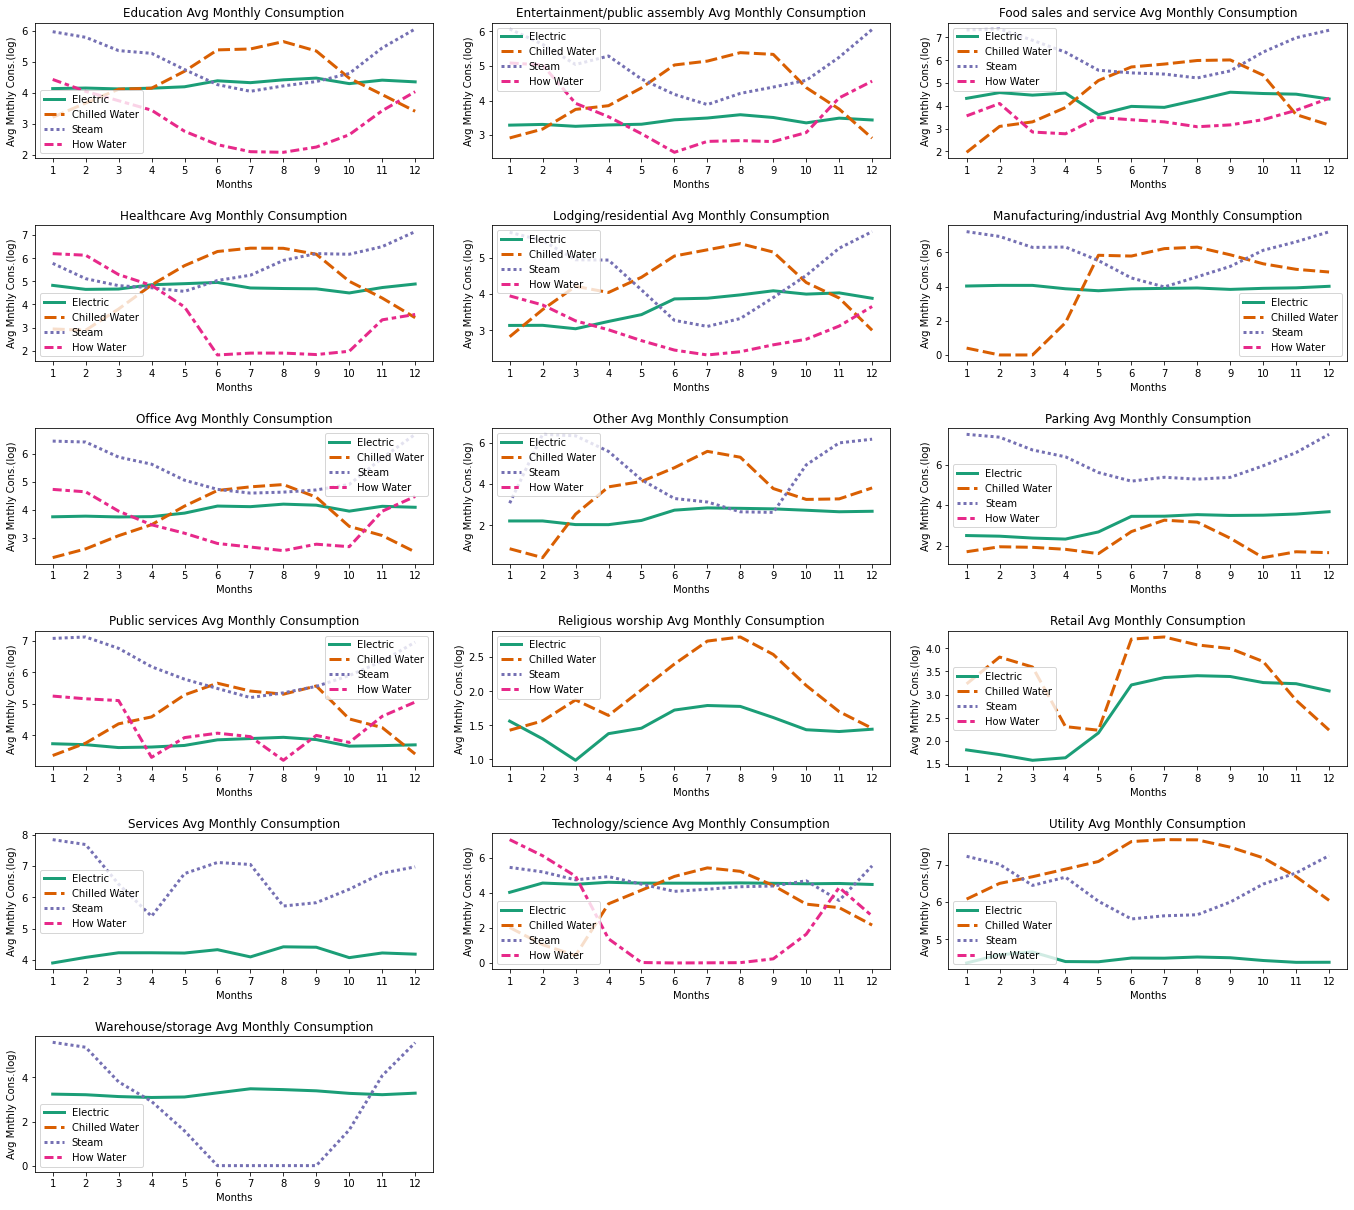

In [ ]:
primary_use_df = data.groupby(['primary_use','month', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()
primary_usage = primary_use_df.primary_use.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(primary_usage)+1):
  if i < len(primary_usage):

    plt.subplot(6,3,i+1)

    sns.lineplot(data= primary_use_df[primary_use_df.primary_use==primary_usage[i]], 
                 x='month', y='meter_reading_transformed', hue='meter', style="meter", 
                 palette='Dark2',linewidth=3)
    ax.set(xlim=(1,12))
    plt.xticks([i for i in range(1,13)]),
    plt.title(str(primary_usage[i])+ " Avg Monthly Consumption")
    plt.xlabel("Months")
    plt.ylabel("Avg Mnthly Cons.(log)")
    plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()


**Observations:**
* For Education, Entertainment/public assembly,Healthcare, Manufacturing/industrial, Technology/science and Warehouse/storage facilities, the average Electricity Consumptions doesn't fluctuate much according to months.
* For Retail and Parking facilities the avg Electricity consumption during first 4 months remains minimum.
* Chilled water usage for almost all the sites is higher during summer.
* Steam and Hot water usage remains low during summer season for all types of buildings excepts for service facilities where usage of steam during summer is high.

#### **7.5.8 Building Usage wise avg Weekly energy consumption**

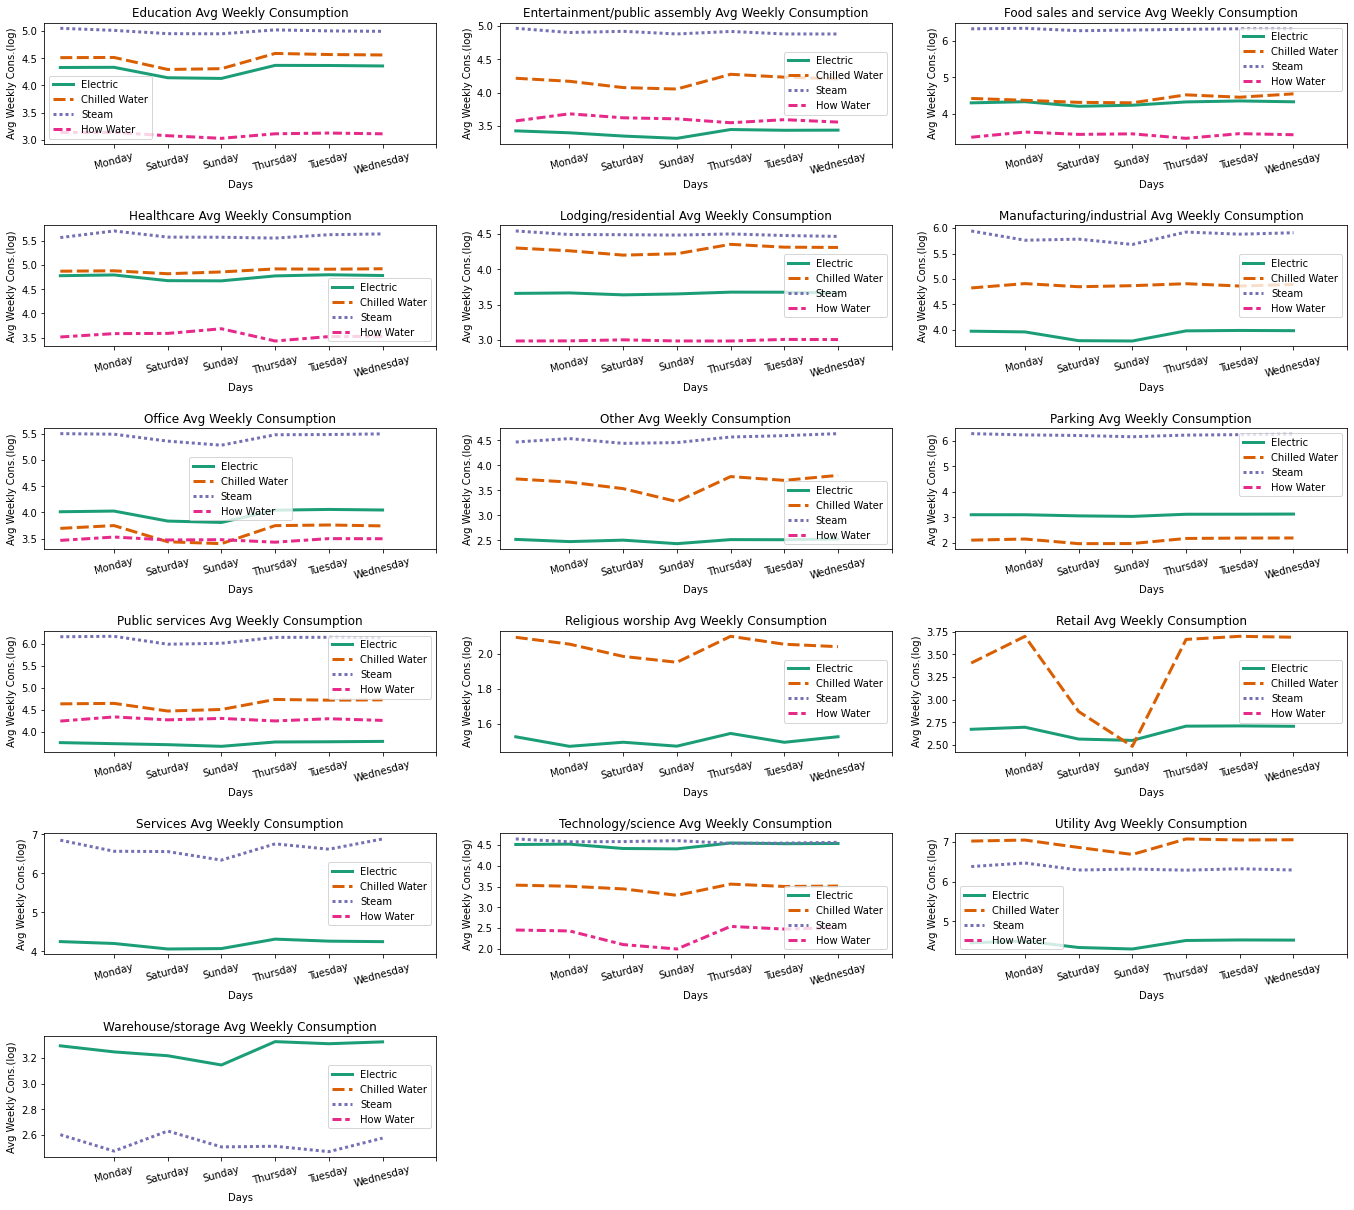

In [ ]:
primary_use_df = data.groupby(['primary_use','day_name', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()

primary_usage = primary_use_df.primary_use.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(primary_usage)+1):
  if i < len(primary_usage):

    plt.subplot(6,3,i+1)

    sns.lineplot(data= primary_use_df[primary_use_df.primary_use==primary_usage[i]], 
                 x='day_name', y='meter_reading_transformed', 
                 hue='meter', style="meter", palette='Dark2',linewidth=3)
    ax.set(xlim=(1,7))
    plt.xticks([i for i in range(1,8)]),
    plt.title(str(primary_usage[i])+ " Avg Weekly Consumption")
    plt.xlabel("Days")
    plt.ylabel("Avg Weekly Cons.(log)")
    plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])
    plt.xticks(rotation = 15)

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()

**Observations:**
* Facilities such as Food sales and service, Lodging/residential and Parking doesn't see much fluctuation in avg electricity consumption as compared to other types of facilities.

#### **7.5.9 Building Usage wise Avg Hourly Energy Consumption during day and night:**

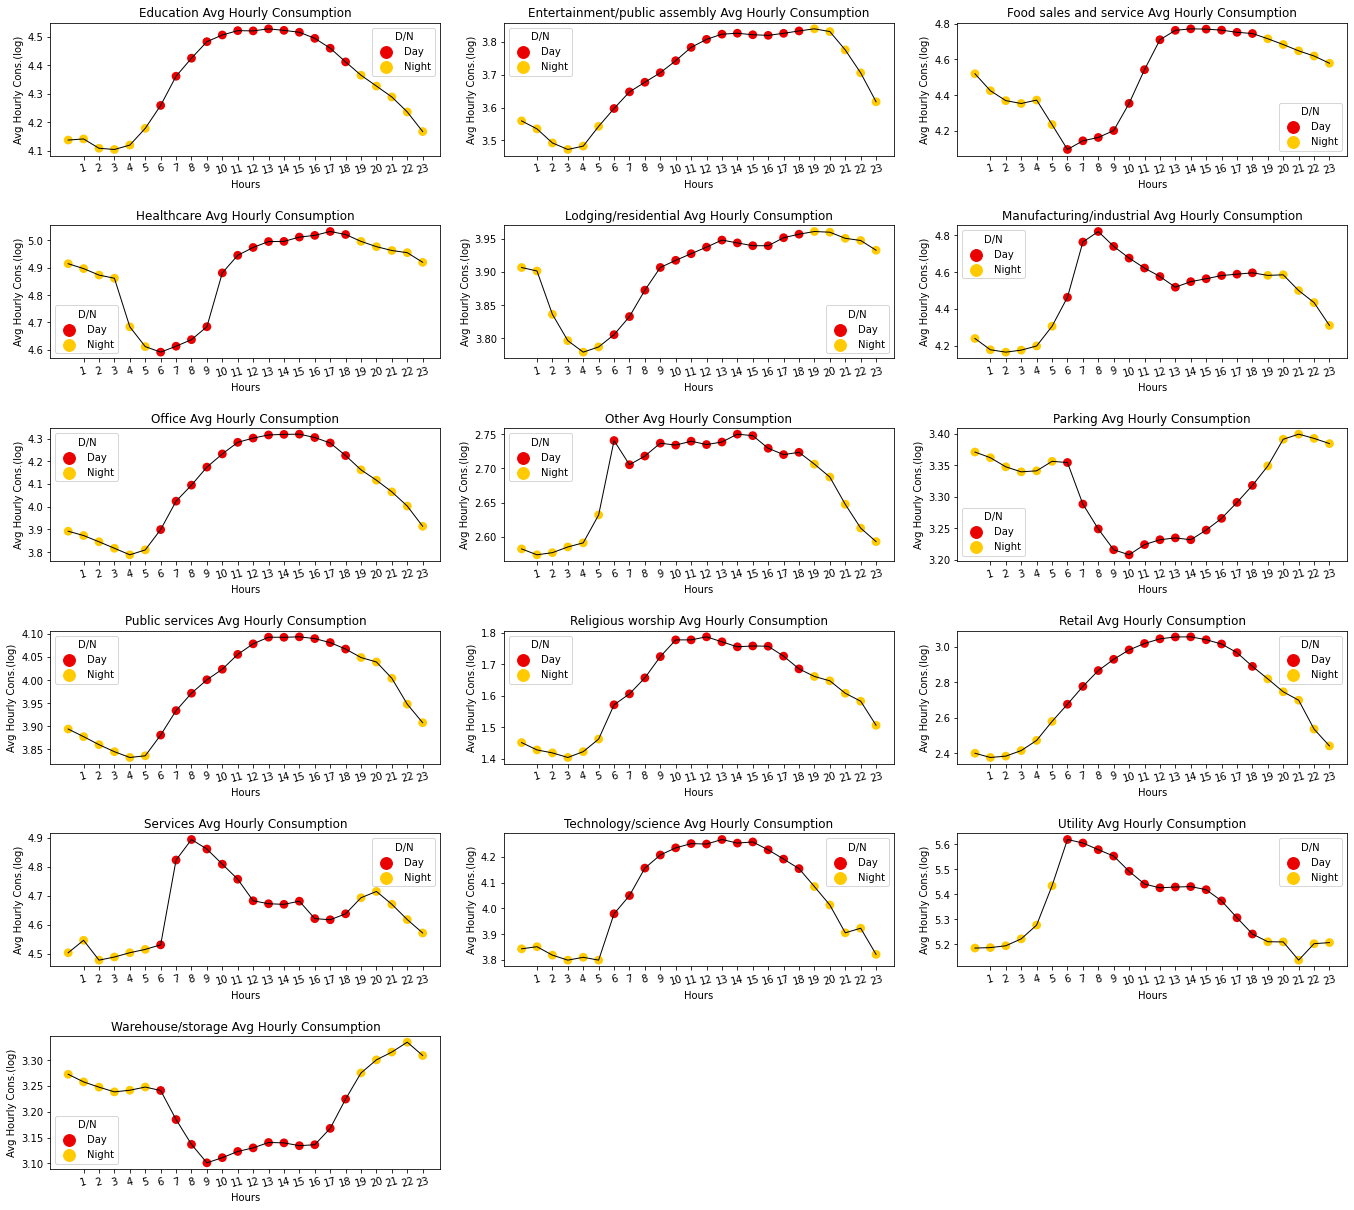

In [ ]:
primary_use_df = data.groupby(['primary_use','hour', 'D/N'], as_index=False)[[ 'meter_reading_transformed', 'D/N']].mean()

primary_usage = primary_use_df.primary_use.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(primary_usage)+1):
  if i < len(primary_usage):

    plt.subplot(6,3,i+1)

    sns.lineplot(data= primary_use_df[primary_use_df.primary_use==primary_usage[i]], 
                 x='hour', y='meter_reading_transformed',  
                 color='black',linewidth=1.0) 
    
    sns.scatterplot(data= primary_use_df[primary_use_df.primary_use==primary_usage[i]].dropna(), 
                 x='hour', y='meter_reading_transformed', hue='D/N', sizes=(140, 140), size='D/N',
                 palette='hot',linewidth=3)
   
    ax.set(xlim=(1,23))
    plt.xticks([i for i in range(1,24)])
    plt.title(str(primary_usage[i])+ " Avg Hourly Consumption")
    plt.xlabel("Hours")
    plt.ylabel("Avg Hourly Cons.(log)")
    plt.xticks(rotation = 15)

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)


**Observations:**
* Parking and Warehouse/storage facilities shows negative trend of energy usage as compared to all other facilities as avg Energy comsumption of these two facilities is low/minimum during day time and high during night hours. For rest of the facilities its opposite.
* **Healthcare** and **Logging facilities** seems to follow same **energy usage trend** where energy comsumption start picking up late in the morning around 9:00 am and remains high until late in the night i.e. 3:00 am. For rest of the facilities, energy consumptions start picking up early in the morning around 6:00 am and dops at night around 08:00 -09:00 
* For **Food sales and services**, Energy consumption starts picking up late in the morning and reaches its pick around 12 am. It remains high until midnight.
* For **Utility facilities**, energy consumption starts picking up relatively early as compared to other facilities with its maximum usage around 07:00 - 08:00 am and it reduces gradually throughout the day.


#### **7.5.10 Site wise Avg Hourly Energy Consumption during day and night:**

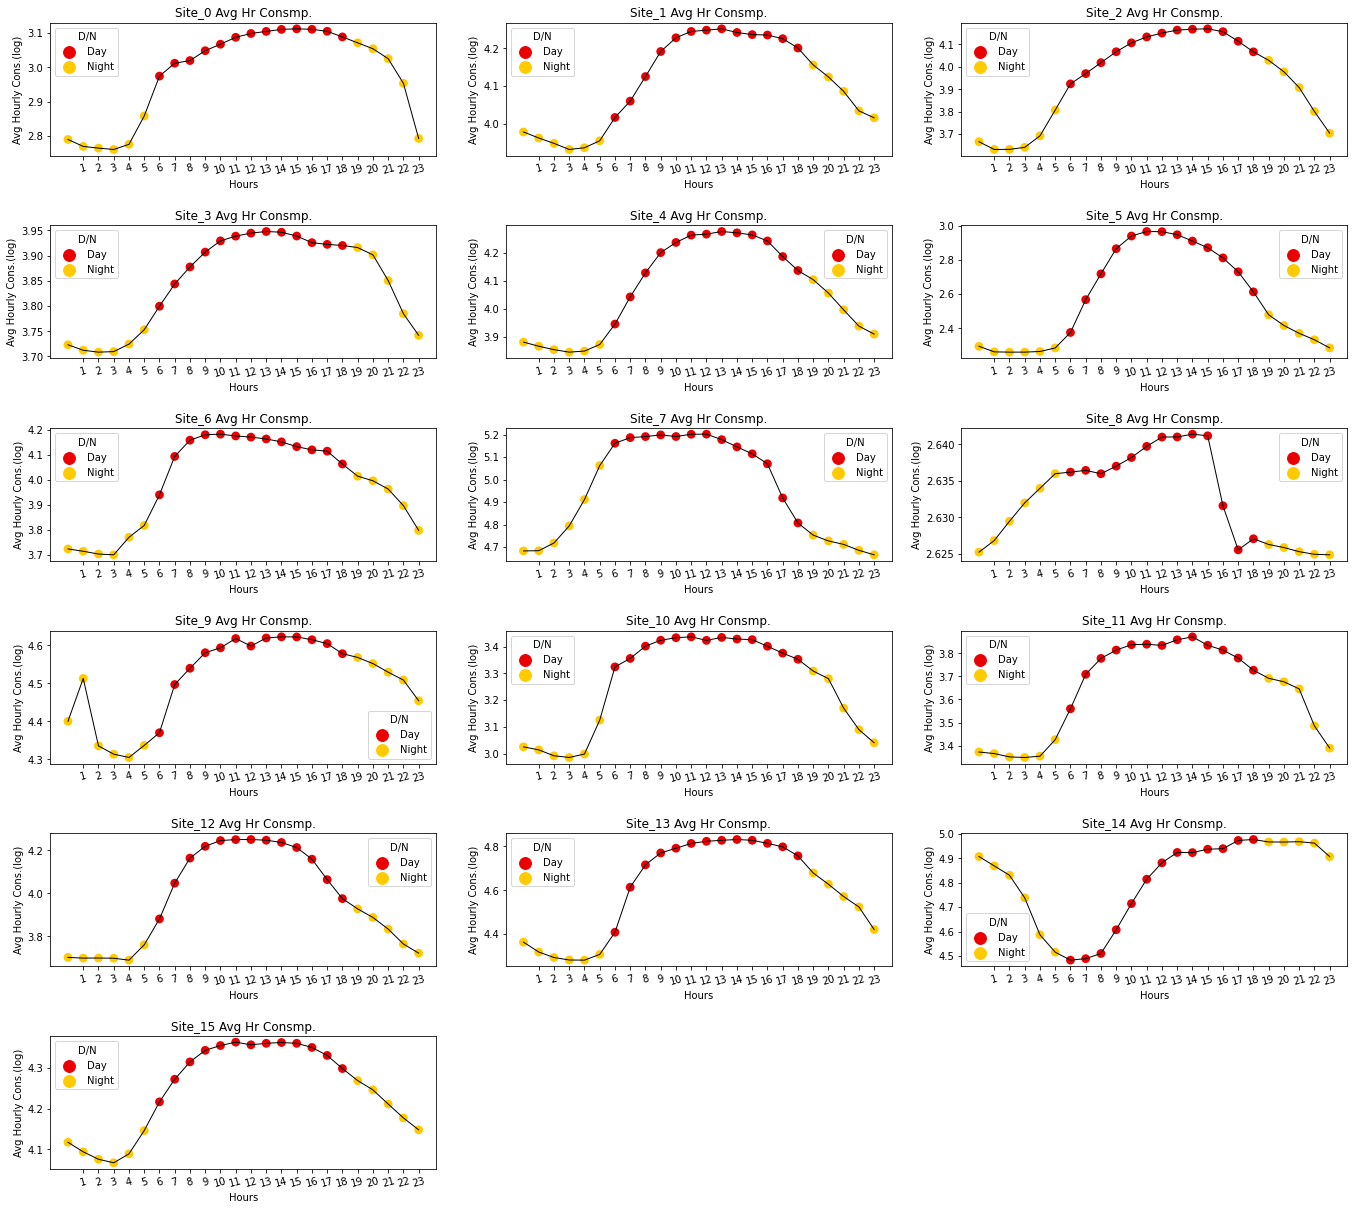

In [ ]:
site_df = data.groupby(['site_id','hour', 'D/N'], as_index=False)[[ 'meter_reading_transformed']].mean()
site_usage = site_df.site_id.unique().tolist()

plt.figure(figsize=(20,18))
for i in range(len(site_usage)+1):
  if i < len(site_usage):
    plt.subplot(6,3,i+1)
    sns.lineplot(data= site_df[site_df.site_id==site_usage[i]], 
                 x='hour', y='meter_reading_transformed',  
                 color='black',linewidth=1.0) 
    sns.scatterplot(data= site_df[site_df.site_id==site_usage[i]].dropna(), 
                 x='hour', y='meter_reading_transformed', hue='D/N', sizes=(140, 140), size='D/N',
                 palette='hot',linewidth=3)
    ax.set(xlim=(1,23))
    plt.xticks([i for i in range(1,24)])
    plt.title("Site_" + str(site_usage[i])+ " Avg Hr Consmp.")
    plt.xlabel("Hours")
    plt.ylabel("Avg Hourly Cons.(log)")
    plt.xticks(rotation = 15)

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)


**OBSERVATIONS:**
* Almost for all the sites, the energy utilization is high during the day and remains low during night hours.
* For site_14, energy utilizaton starts picking up relatively late around 10:00 am and remain high late in the night.
* For site_08 energy consumption starts picking up early in the morning around 01:00 am and it drops sharply after 04:00 pm.

### **7.6 Checking Feature Correlation:**

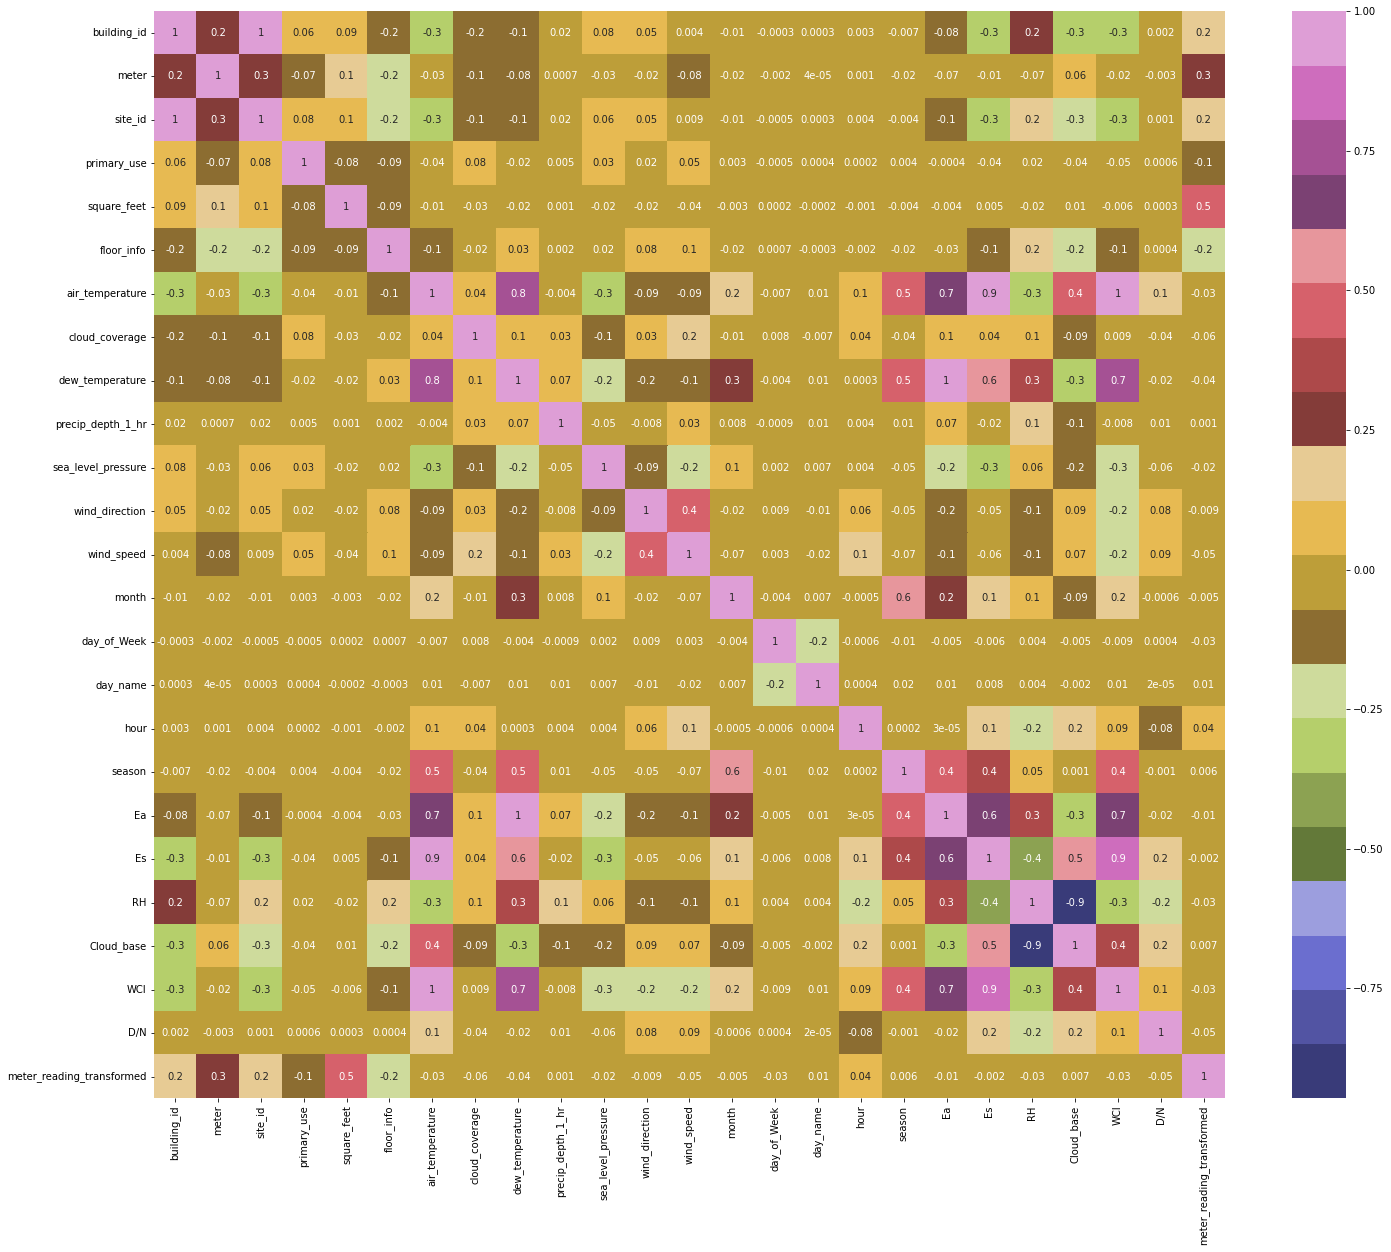

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#Reference https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
#get correlations of each features in dataset
data = data_cleaned.drop(['year'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(24,20))
g=sns.heatmap(data[top_corr_features].corr(),annot=True, fmt='.1g', cmap='tab20b')

**Observations:**
* Features building_id and site_id are highly correlated.
* The derived features such as WCI are highly correlated with the features from which it has derived i.e. dew_temperature and Ea and Es which is obvisous. It might be beneficial if we drop the basic features and keep only derived features.  

_________________

# **8. Handling Missing Values and Data Cleaning**

#### **8.1 Dealing with Meter Reading ==0**

##### **8.1.1 Let's find out % missing readings site-wise**

In [ ]:
def percent_zero_count(data, site_id, meter_type):
  sliced_df = data.loc[(data.site_id==site_id) & (data.meter==meter_type)]
  if len(sliced_df) !=0:
    counts = list(sliced_df.meter_reading_transformed.isin([0.000000]).value_counts())
    if len(counts) > 1:
      zero_count = counts[1]
    else:
      zero_count = 0
    total_values = len(sliced_df)
    zero_count_percnt = np.round((zero_count/total_values)*100, 2)
  else:
    zero_count_percnt = 0
  return zero_count_percnt

In [ ]:
meter_0_missing , meter_1_missing, meter_2_missing, meter_3_missing = [],[],[],[]
site_ids = ['site_' + str(i) for i in range(len(list(data.site_id.unique())))]
meter_types = list(sorted(data.meter.unique()))

for i in tqdm(range(len(site_ids))):
  for j in range(len(meter_types)):
    percent_zeros = percent_zero_count(data, i, j)
    if j==0:
      meter_0_missing.append(percent_zeros) 
    elif j==1:
      meter_1_missing.append(percent_zeros) 
    elif j==2:
      meter_2_missing.append(percent_zeros) 
    else:
      meter_3_missing.append(percent_zeros)


missing_values = pd.DataFrame([meter_0_missing, meter_1_missing,meter_2_missing,meter_3_missing]).T
missing_values['site_ids'] = site_ids
missing_values.columns = ["Electric_Meter", "Chilledwater_Meter", "Steam-Energy_Meter", "Hot_Water_Meter", 'site_ids']
order = ['site_ids',"Electric_Meter", "Chilledwater_Meter", "Steam-Energy_Meter", "Hot_Water_Meter"]
missing_values = missing_values[order]

100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


100%|██████████| 4/4 [00:00<00:00, 17.15it/s]


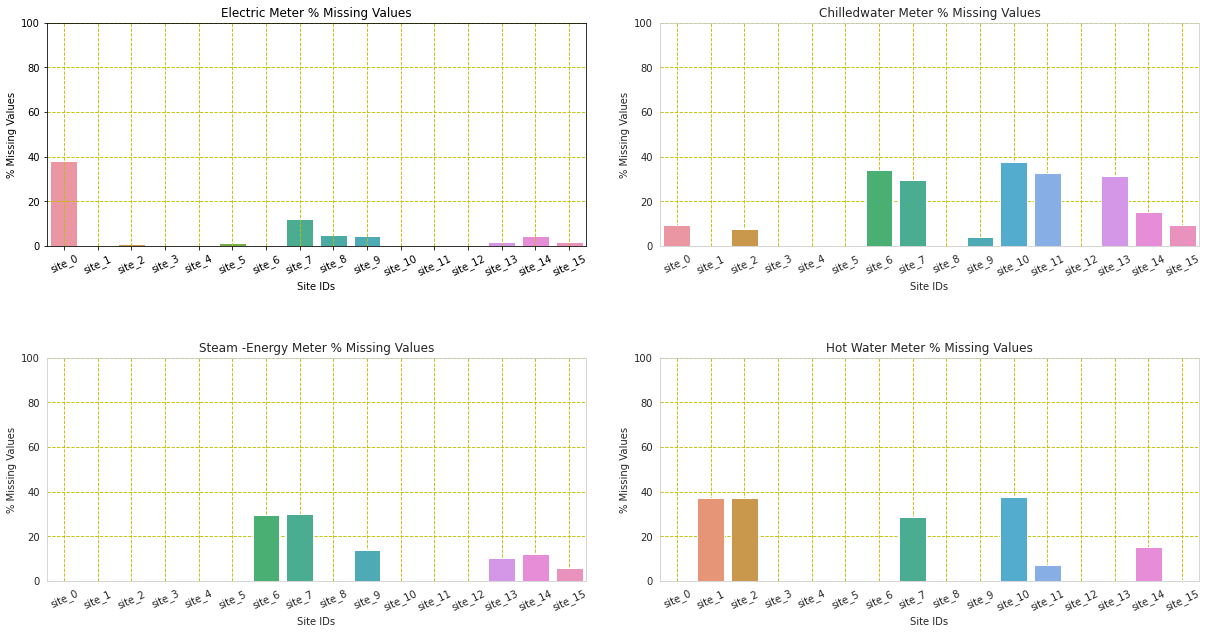

In [ ]:
columns = list(missing_values.columns)
meter_names = ["Electric Meter", "Chilledwater Meter", "Steam -Energy Meter", "Hot Water Meter"]

plt.figure(figsize=(18,10))

for i in tqdm(range(len(meter_types))):
  if i < len(meter_types):
    plt.subplot(2,2,i+1)
   
    sns.set_style("whitegrid" , {"grid.color": "y", "grid.linestyle": "--"})
    sns.barplot(data=missing_values, x=columns[0], y=columns[i+1])
    sns.color_palette("light:b", as_cmap=True)
    plt.ylabel("% Missing Values")
    plt.title(meter_names[i] + " % Missing Values")
    plt.xlabel("Site IDs")

    plt.grid(color='y', linestyle='--', linewidth=0.9)
    plt.xticks(rotation = 25)
    plt.ylim(0, 100)

plt.tight_layout(pad=5, h_pad=5, w_pad=3, rect=None)
plt.show()

**Observations:**
* All the dour types of meter have zero meter readings. There can be various reasons for that.
* For site 7, around 30% of Chilledwater_Meter, Steam-Energy_Meter and Hot_Water_Meter readings are recordes as a zero. 
* For site 1 and site 2, around 40% of Hot_water meter readings recorded as a zero.
* Practically it is possible that  Chilledwater_Meter, Steam-Energy_Meter or Hot_Water_Meter have zero meter recorded at particular instance of time however for Electricity, it is not acceptable that large number of meter readings recorded as a zero unless and until there is some reasonable explanation for that.
* For **site_0**, we can observe that almost **38% of electric meter readings are recorded as a zero.** Next for site 7, its 12% and for rest of the sites its percentage is less than 5%.

##### **8.1.2 Analyse Site_0 and Site_07 Further**

**As we have observed some anamolies in the Site_0 and Site_7 meter readings, Lets analyse it further.**

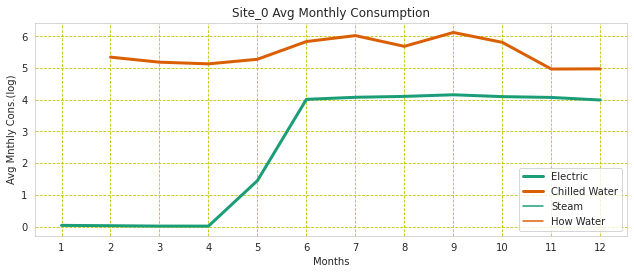

In [ ]:
#fig,ax = plt.subplots(figsize=(12,4))
site_df = data.groupby(['site_id','month', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()
site_ids = site_df.site_id.unique().tolist()

plt.figure(figsize=(10,5))
sns.lineplot(data= site_df[site_df.site_id==site_ids[0]], x='month', y='meter_reading_transformed', 
             hue='meter', palette='Dark2',linewidth=3)
#ax.set(xlim=(1,12))
plt.xticks([i for i in range(1,13)]),
plt.title("Site_" + str(site_ids[0])+ " Avg Monthly Consumption")
plt.xlabel("Months")
plt.ylabel("Avg Mnthly Cons.(log)")
plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()

**Observations:**
* Electrical meter readings is zero upto 4th month. There could be various possible readons for that. The equipment which is recording the readings might be faulty or they have started recording the data from 4th month onwards. Individual meter readings are zero at few instances.

**For site_07, since % of zero meter readings for electric meter is high i.r. 12%, lets analyse it further to see if it folloes any firm pattern like site_o.**

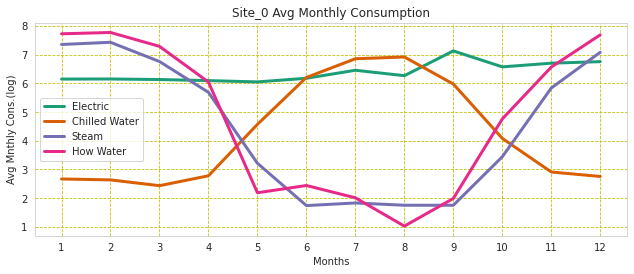

In [ ]:
#fig,ax = plt.subplots(figsize=(12,4))
site_df = data.groupby(['site_id','month', 'meter'], as_index=False)[[ 'meter_reading_transformed']].mean()
site_ids = site_df.site_id.unique().tolist()

plt.figure(figsize=(10,5))
sns.lineplot(data= site_df[site_df.site_id==site_ids[7]], x='month', y='meter_reading_transformed', 
             hue='meter', palette='Dark2',linewidth=3)
#ax.set(xlim=(1,12))
plt.xticks([i for i in range(1,13)]),
plt.title("Site_" + str(site_ids[0])+ " Avg Monthly Consumption")
plt.xlabel("Months")
plt.ylabel("Avg Mnthly Cons.(log)")
plt.legend(labels=["Electric","Chilled Water","Steam","How Water"])

plt.tight_layout(pad=5, h_pad=2, w_pad=2, rect=None)
plt.show()

**Observations:**
* Unlike site_0 where total average reading for initial 4 months is zero, site_7 doesn't show any firm pattern in average zero readings. 

##### **8.1.3 Analyzing Electrical Readings of each building from site_0.**

100%|██████████| 106/106 [00:43<00:00,  2.44it/s]


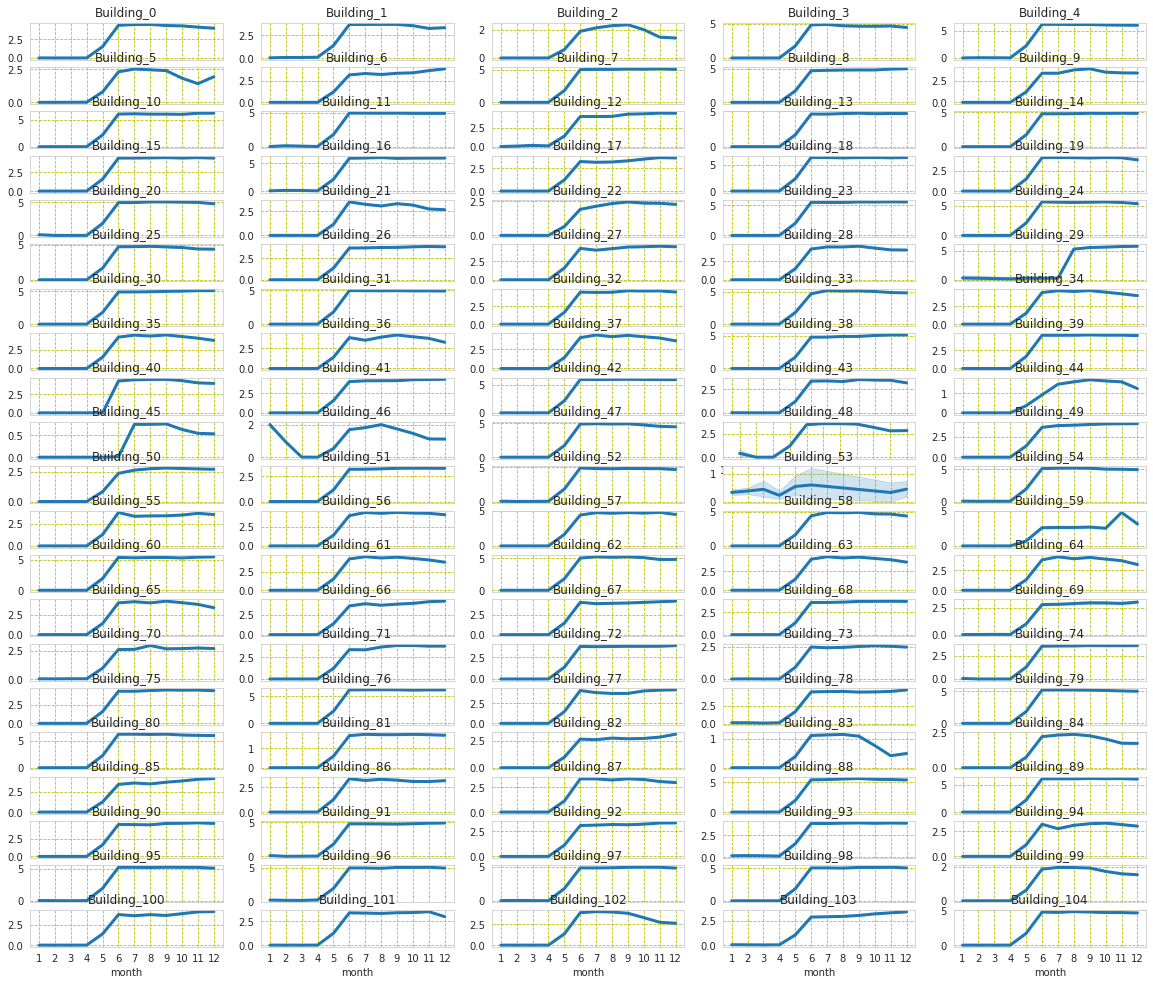

In [ ]:
site_0_df = data[data.site_id==0]
site_0_df_electrical = site_0_df[site_0_df.meter == 0]
building_list = sorted(site_0_df.building_id.unique().tolist())
plt.figure(figsize=(20,17))
for i in tqdm(range(len(building_list)+1)):
  if i < len(building_list):
    plt.subplot(21,5,i+1)
    sns.lineplot(data=site_0_df_electrical[site_0_df_electrical.building_id==i], x='month', y='meter_reading_transformed', 
                hue=None, palette='Dark2',linewidth=3)  
    plt.xticks([i for i in range(1,13)]),
    plt.ylabel("")
    plt.title('Building_'+str(i))
plt.tight_layout(pad=10.0, rect=None)
plt.show()

**Observations:**
* Except for building no 46 and 53, it can be observed that Electrical meter readings for all the buildings are recorded as a zero for intial 4 months.
* **Since this is the case, I think imputation of zero meter readings will not work properly and better option will be to discard these readings.**

##### **8.1.4 Removing Datapoints with meter readings = 0**

In [ ]:
np.round((len(data[data.meter_reading==0.000000])/len(data))*100, 2)

9.27

So we have roughly 9.30% of the meter readings = 0 values. This doesn't add any value to our model therefore discarding these datapoints

In [ ]:
data_cleaned = data[data.meter_reading != 0.000000]
len(data_cleaned)

18342124

#### **8.2 Handling Missing Values**

In [ ]:
#data_cleaned = data_cleaned.drop(['Unnamed: 0'], axis=1)
missing_values = pd.DataFrame(data_cleaned.isnull().sum())
missing_values.columns = ['total_missing_points']
missing_values['% missing_datapoints'] = missing_values.apply(lambda x: np.round((x/len(data_cleaned)*100),2) for x in missing_values)
missing_values

total_missing_points  % missing_datapoints
Unnamed: 0                                    0                  0.00
building_id                                   0                  0.00
meter                                         0                  0.00
timestamp                                     0                  0.00
meter_reading                                 0                  0.00
site_id                                       0                  0.00
primary_use                                   0                  0.00
square_feet                                   0                  0.00
year_built                             11033911                 60.16
floor_count                            15088792                 82.26
floor_info                                    0                  0.00
air_temperature                           89448                  0.49
cloud_coverage                          7975742                 43.48
dew_temperature                           92543                  0.50
precip_depth_1_hr                       3521887                 19.20
sea_level_pressure                      1187819                  6.48
wind_direction                          1326132                  7.23
wind_speed                               132577                  0.72
timestamp_                                84406                  0.46
year                                      84406                  0.46
month                                     84406                  0.46
day_of_Week                               84406                  0.46
day_name                                  84406                  0.46
hour                                      84406                  0.46
season                                    84406                  0.46
Ea                                        92543                  0.50
Es                                        89448                  0.49
RH                                        92543                  0.50
Cloud_base                                92543                  0.50
WCI                                      133671                  0.73
D/N                                       84406                  0.46
meter_reading_corrected                       0                  0.00
meter_reading_transformed                     0                  0.00

**Observations:**
* For the feature **year_built**, around 60% data is missing. 
* For the cloud coverage, around 43% data is missing. Let's try to compute the season-wise mean and fill the missing values based on the season.
* For rest of the features, less than 1% data is missing. Let's fill that using the mean.

##### **8.2.1 Dropping the feature year_built.**

In [ ]:
data_cleaned = data_cleaned.drop(['year_built'], axis=1)

##### **8.2.2 Replacing Cloud_Coverrage missing data with season wise average value.**

In [ ]:
cloud_avg_df = data_cleaned.groupby(['season'], as_index=False)['cloud_coverage'].mean()
cloud_avg_df.columns = ['season', 'cloud_avg']
data_cleaned = data_cleaned.merge(cloud_avg_df, on='season')
data_cleaned['cloud_coverage'] = data_cleaned['cloud_coverage'].fillna(data_cleaned['cloud_avg'])
data_cleaned = data_cleaned.drop(['cloud_avg'], axis=1)

##### **8.2.3 Replacing Other Feature's missing values with their mean values**

In [ ]:
#Reference:https://stackoverflow.com/questions/55124655/imputing-only-the-numerical-values-using-sci-kit-learn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)

numeric_columns = data_cleaned.select_dtypes(include='number').columns
data_cleaned[numeric_columns] = pd.DataFrame(imputer.fit_transform(data_cleaned[numeric_columns]), columns=numeric_columns)
data_cleaned = data_cleaned.drop(['Unnamed: 0'], axis=1)

In [ ]:
missing_values = pd.DataFrame(data_cleaned.isnull().sum())
missing_values.columns = ['total_missing_points']
missing_values['% missing_datapoints'] = missing_values.apply(lambda x: np.round((x/len(data_cleaned)*100),2) for x in missing_values)
missing_values

total_missing_points  % missing_datapoints
building_id                                   0                   0.0
meter                                         0                   0.0
timestamp                                     0                   0.0
meter_reading                                 0                   0.0
site_id                                       0                   0.0
primary_use                                   0                   0.0
square_feet                                   0                   0.0
floor_count                                   0                   0.0
floor_info                                    0                   0.0
air_temperature                               0                   0.0
cloud_coverage                                0                   0.0
dew_temperature                               0                   0.0
precip_depth_1_hr                             0                   0.0
sea_level_pressure                            0                   0.0
wind_direction                                0                   0.0
wind_speed                                    0                   0.0
timestamp_                                    0                   0.0
year                                          0                   0.0
month                                         0                   0.0
day_of_Week                                   0                   0.0
day_name                                      0                   0.0
hour                                          0                   0.0
season                                        0                   0.0
Ea                                            0                   0.0
Es                                            0                   0.0
RH                                            0                   0.0
Cloud_base                                    0                   0.0
WCI                                           0                   0.0
D/N                                           0                   0.0
meter_reading_corrected                       0                   0.0
meter_reading_transformed                     0                   0.0

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Study 01/Data/data_cleaned.csv'):
  data_cleaned.to_csv("/content/drive/MyDrive/Case Study 01/Data/data_cleaned.csv", index=False)
else:
  data_cleaned = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/data_cleaned.csv")
  data_cleaned = reduce_mem_usage(data_cleaned)

Memory usage of dataframe is 4318.16 MB
Memory usage after optimization is: 1132.53 MB
Decreased by 73.8%


### **8.3 Dealing with Outliers:**
<br>The points which can be considered as an outlier are constant meter readings for long period of time, out of range positive and negative spikes in the readings, zero-meter readings, meter readings taken even before buildings are built etc.

In [ ]:
data_cleaned = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/data_cleaned.csv")
data_cleaned = reduce_mem_usage(data_cleaned)

Memory usage of dataframe is 4178.86 MB
Memory usage after optimization is: 1097.33 MB
Decreased by 73.7%


#### **8.4.1 Box Plots:**

Let's try using Box Plot for outlier detections. Any points out of minimum and maximum  range may represent outliers.

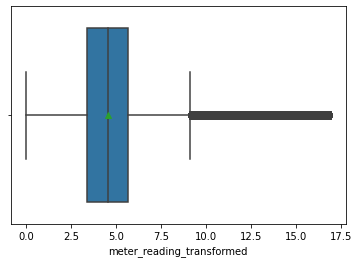

--------------------------------------------------
Minimum Value: -0.023125886917114258, 
Maximum Value: 9.108402967453003


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=data_cleaned.meter_reading_transformed, showmeans=True)
plt.xlabel("meter_reading_transformed")
plt.show()

#Reference: https://www.statology.org/interquartile-range-python/
#Reference: https://www.youtube.com/watch?v=A3gClkblXK8
q3, q1 = np.percentile(data_cleaned.meter_reading_transformed, [75 ,25])
IQR = q3 - q1

lower_limit = q1 - 1.5*IQR
upper_limit = q3 + 1.5*IQR
print('--'*25)
print("Minimum Value: {0}, \nMaximum Value: {1}".format(lower_limit, upper_limit))

**Observations:**
* Minimum values represent **-ve** value. Which represents **Fractions**.  
* There are few datapoints whose meter readings (trasformed) is beyond the Maximum value i.e. 9.108402967453003. There points might represents the outliers.

In [ ]:
data_cleaned[data_cleaned.meter_reading_transformed > 9.0888671875][['building_id', 'meter_reading_corrected',	'meter_reading_transformed']]

building_id  meter_reading_corrected  meter_reading_transformed
765            1088.0             1.746880e+04                   9.768229
787            1099.0             3.241630e+06                  14.991587
795            1104.0             1.760160e+04                   9.775802
801            1107.0             2.003910e+04                   9.905491
864            1148.0             5.512500e+04                  10.917377
...               ...                      ...                        ...
18257081       1148.0             2.922660e+04                  10.282868
18257103       1159.0             2.568750e+04                  10.153799
18257122       1168.0             3.675000e+04                  10.511921
18257170       1197.0             3.684380e+04                  10.514470
18257372       1284.0             1.443030e+04                   9.577155

[107427 rows x 3 columns]

#### **8.4.2 Line Plots:**

Let's plot the average meter readings of each building.

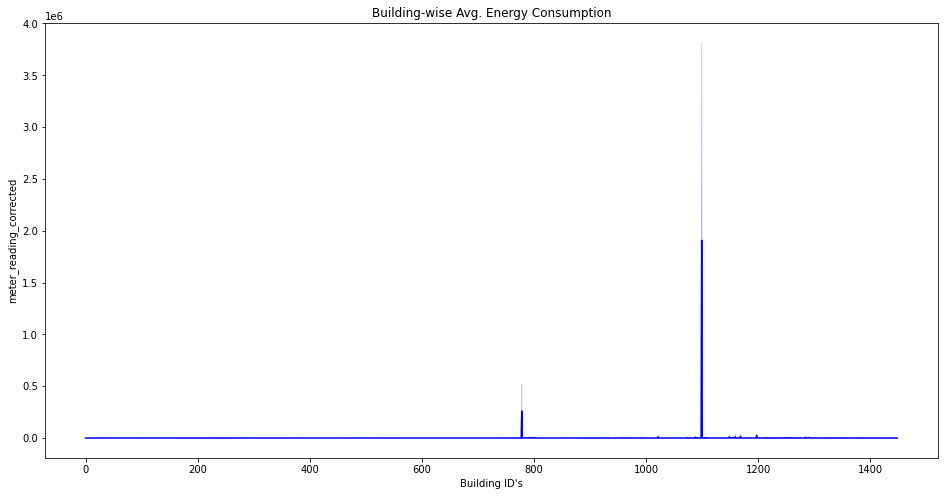

99th percentile value of meter reading = 5531.25       
100th percentile value of meter reading is = 21904700.0      
and their difference = 21899168 
--------------------------------------------------
Building with building_id 1099 has maximum average meter reading = 3814315.25 
--------------------------------------------------


In [ ]:
building_avg= data_cleaned.groupby(['building_id','meter'], as_index=False)[['meter_reading_corrected','meter']].mean()

plt.figure(figsize=(16,8))
sns.lineplot(x = building_avg.building_id, y=building_avg.meter_reading_corrected, color='blue', err_style="band")
plt.xlabel("Building ID's")
plt.title("Building-wise Avg. Energy Consumption")
plt.show()

percentile99 = data_cleaned.meter_reading_corrected.quantile(0.99)
percentile100 = data_cleaned.meter_reading_corrected.quantile(1)
print("99th percentile value of meter reading = {0} \
      \n100th percentile value of meter reading is = {1}\
      \nand their difference = {2} \n{3}"
      .format(percentile99,percentile100, int(percentile100 - percentile99), "--"*25))

max_reading = building_avg.meter_reading_corrected.max()
print("Building with building_id {1} has maximum average meter reading = {0} \n{2}"
      .format(building_avg[building_avg.meter_reading_corrected==max_reading].meter_reading_corrected.values[0], 
      int(building_avg[building_avg.meter_reading_corrected==max_reading].building_id.values[0]), "--"*25))

**Observations:**
* Building with `building_id = 1099` shows sudden spikes in the meter reading. This may dominate entire model and therefore we will treat this as an outlier. 
* There another spike in the meter reading. LEts analyse this further after removing first spike.

Dropping all the readings from `building_id = 1099.`

In [ ]:
outliers = list(data_cleaned[data_cleaned.building_id == 1099.0].index)
data_cleaned.drop(index=outliers, axis=0, inplace = True)

Let's analyse next spike in the meter reading.

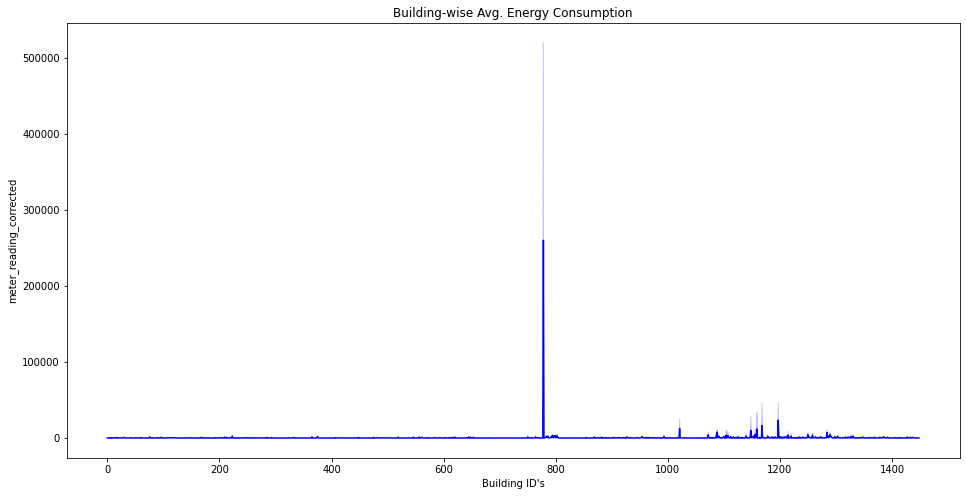

99th percentile value of meter reading = 5437.5       
100th percentile value of meter reading is = 880374.0      
and their difference = 874936 
--------------------------------------------------
Building with building_id 778 has maximum average meter reading = 519921.65625 
--------------------------------------------------


In [ ]:
building_avg= data_cleaned.groupby(['building_id','meter'], as_index=False)[['meter_reading_corrected','meter']].mean()

plt.figure(figsize=(16,8))
sns.lineplot(x = building_avg.building_id, y=building_avg.meter_reading_corrected, color='blue', err_style="band")
plt.xlabel("Building ID's")
plt.title("Building-wise Avg. Energy Consumption")
plt.show()

percentile99 = data_cleaned.meter_reading_corrected.quantile(0.99)
percentile100 = data_cleaned.meter_reading_corrected.quantile(1)
print("99th percentile value of meter reading = {0} \
      \n100th percentile value of meter reading is = {1}\
      \nand their difference = {2} \n{3}"
      .format(percentile99,percentile100, int(percentile100 - percentile99), "--"*25))

max_reading = building_avg.meter_reading_corrected.max()
print("Building with building_id {1} has maximum average meter reading = {0} \n{2}"
      .format(building_avg[building_avg.meter_reading_corrected==max_reading].meter_reading_corrected.values[0], 
      int(building_avg[building_avg.meter_reading_corrected==max_reading].building_id.values[0]), "--"*25))

**Observations:**
* Building with `building_id = 778` also shows sudden spikes in the meter reading. This may also  dominate entire model and therefore we will treat this as an outlier. 


Dropping all the readings from `building_id = 778.`

In [ ]:
outliers = list(data_cleaned[data_cleaned.building_id == 778.0].index)
data_cleaned.drop(index=outliers, axis=0, inplace = True)

Let's analyse further:

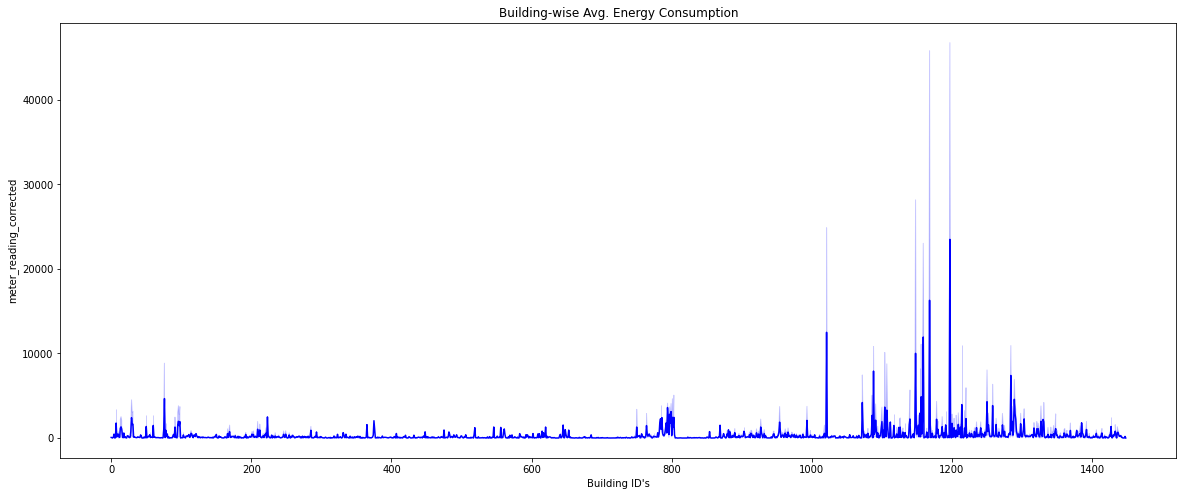

99th percentile value of meter reading = 5698.39990234375       
100th percentile value of meter reading is = 356640.0      
and their difference = 350941 
--------------------------------------------------
Building with building_id 1197 has maximum average meter reading = 46760.9685006569 
--------------------------------------------------


In [ ]:
building_avg= data_cleaned.groupby(['building_id','meter'], as_index=False)[['meter_reading_corrected','meter']].mean()

plt.figure(figsize=(20,8))
sns.lineplot(x = building_avg.building_id, y=building_avg.meter_reading_corrected, color='blue', err_style="band")
plt.xlabel("Building ID's")
plt.title("Building-wise Avg. Energy Consumption")
plt.show()

percentile99 = data_cleaned.meter_reading_corrected.quantile(0.99)
percentile100 = data_cleaned.meter_reading_corrected.quantile(1)
print("99th percentile value of meter reading = {0} \
      \n100th percentile value of meter reading is = {1}\
      \nand their difference = {2} \n{3}"
      .format(percentile99,percentile100, int(percentile100 - percentile99), "--"*25))

max_reading = building_avg.meter_reading_corrected.max()
print("Building with building_id {1} has maximum average meter reading = {0} \n{2}"
      .format(building_avg[building_avg.meter_reading_corrected==max_reading].meter_reading_corrected.values[0], 
      int(building_avg[building_avg.meter_reading_corrected==max_reading].building_id.values[0]), "--"*25))

**Observations:**
* After removing two buildings data, the average energy usage pattern seems to be relatively stable with ith few spikes. Let's ignore them for now. Will treat them as an outliers if required.  


### **8.4 Data Encoding and Standardization:**

In [ ]:
data_cleaned = data_cleaned.drop(['timestamp_'], axis=1)
categorical_columns = data_cleaned.select_dtypes(include='category').columns.tolist()
numeric_columns = data_cleaned.select_dtypes(include='number').columns.tolist()

In [ ]:
categorical_columns

['timestamp', 'primary_use', 'day_name', 'D/N']

#### **8.3.1 Handling Categorical Features:**

In [ ]:
categorical_columns = data_cleaned.select_dtypes(include='category').columns.tolist()
print("Categorical Features Are:\n  1.{0},\n  2.{1},\n  3.{2},\n  4.{3} ".format(*categorical_columns))

Categorical Features Are:
  1.timestamp,
  2.primary_use,
  3.day_name,
  4.D/N 


In [ ]:
categorical_columns = data_cleaned.select_dtypes(include='category').columns.tolist()

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for features in categorical_columns:
  if features!= 'timestamp':
    data_cleaned[features] = encoder.fit_transform(data_cleaned[features])
  

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.csv'):
  data_cleaned.to_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.csv", index = False)
else:
  data_cleaned = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.csv")
  data_cleaned = reduce_mem_usage(data_cleaned)

Memory usage of dataframe is 4172.64 MB
Memory usage after optimization is: 1095.70 MB
Decreased by 73.7%


#### **8.3.2 Handling Numerical Data:**

In [ ]:
numeric_columns

['building_id',
 'meter',
 'meter_reading',
 'site_id',
 'square_feet',
 'floor_count',
 'floor_info',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'year',
 'month',
 'day_of_Week',
 'hour',
 'season',
 'Ea',
 'Es',
 'RH',
 'Cloud_base',
 'WCI',
 'meter_reading_corrected',
 'meter_reading_transformed']

**Observations:**

Decision Tree based algorithms doesn't required Data Standardization/Scaling.<br>
However Since we are using Linear Regression as a base model, lets create seperate dataframe and standardize its numerical features (Excepts target variables).

In [ ]:
data_cleaned_lr = data_cleaned.copy()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for features in numeric_columns:
  if features not in ['meter_reading', 'meter_reading_corrected', 'meter_reading_transformed']:
    data_cleaned_lr[features] = scaler.fit_transform(data_cleaned_lr[features].values.reshape(-1,1))



In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.csv"):
  data_cleaned_lr.to_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.csv", index = False)
else:
  data_cleaned_lr = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.csv")
  #data_cleaned_lr = reduce_mem_usage(data_cleaned)

# **9. Evaluation Matrics:**

#### **9.1 Root Mean Squared Error (RMSE):**
RMSE represents the standard deviation of the residuals. It gives an idea about how large the residuals are being dispersed. Interpretability of RMSE is relatively high as compared with MSE as it possesses same units as that of the datapoints. RSME is useful when the lower residual values are preferred.

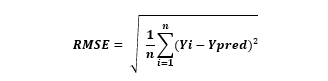

In [ ]:
def compute_RMSE(y_true, y_pred):
  from sklearn.metrics import mean_squared_error
  RMSE = np.round(math.sqrt(mean_squared_error(y_true, y_pred)),2)
  return RMSE

RMSE might be the most appropriate evaluation matrics for this case study because RMSE has below advantages:
* The unit of RMSE is same as that of target variable, which makes it relatively more intrepretable in terms of measurement of units as compared to MSE.
* RSME gives more weight to greater errors than MAE.  It has more strict behaviour while pennalizing larger errors.
* As RMSE takes square of errors, it makes it more sensative to outliers in error distribution. 
* In this case study, after performing targer transformation (log-transformation), we can see that it follows a kind of normal distribution ***(Refer section 7.3)***. And many studies indicates that RSME is appropriate performance metrics for samples with normal distribution.


#### **9.2 Root Mean Squared Logarithmic Error (RMSLE):**

RMSLE is basically a modification of RMSE. As name suggest, errors are calculated on the logarithmic scale.When the actual and predicted values are same, the RMSLE will become undefined as the log of zero is undefined. To prevent this, the constant ‘1’ is added to both actual and predicted values to prevent. Unlike MSE, it doesn’t penalize large errors differently.

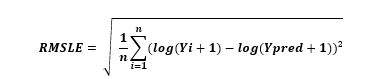

In [ ]:
def compute_RMSLE(y_true, y_pred):
  from sklearn.metrics import mean_squared_log_error
  #Problem: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  #Replace negative predicted values = 0 to avoid value errors.
  y_pred_ = np.where(y_pred <0 , 0, y_pred)  
  RMSLE = np.round(math.sqrt(mean_squared_log_error(y_true, y_pred_)),2)
  return RMSLE

RMSLE is usually used when both predicted and true values are huge numbers and  we dont want to pennalise huge residual errors. Below is the comparison between RMSE and RMSLE values. [Ref.](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)
* If both predicted and actual values are small: RMSE and RMSLE are same.
* If either predicted or the actual value is big: RMSE > RMSLE
* If both predicted and actual values are big: RMSE > RMSLE (RMSLE becomes almost negligible).

<br>RMSLE might also be appropriate evaluation matrics for this case study because RMSLE adress some of the problems faced when we use RMSE as a matrics. [Ref.](https://https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

* **Robustness:** RMSLE is more robust than RMSE. In the case of RMSE, if the data contains extreme outliers, the error term can explode to a very high value. In RMSLE since log term is used, it scale down the effect of outliers. RMSLE errors does not gets affected much by outliers. We have many outliers in our dataset. (***Refer section 8.4.2.*** )
* **Biased Penalty:** RMSLE value is high when predicted value is less than Actual value. On the other hand, RMSLE is low when Predicted value is more than the Actual value. This property can be helpful in this caase study as we are predicting the Energy consumptions how much energy any building would have consumed without any retrofit and users are gettng paid according to the difference between the energy consumed after retrofit and would have been consumed without any retrofit. 

#### **9.3	Coefficient of Variation of the RMSE CV(RMSE):**
Cofficient of variation(CV), is also known as relative standard drviation. It is a standardised measure of dispersion and often expressed as a pecentage. 
CV(RMSE) is a modified version of RMSE. RMSE is normalized by average of target variables. 


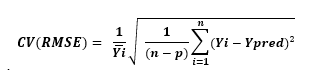

<br> Where in, 
<br>	`Y ̅i – Average of measured (target) values`
<br>`	N – Number of compared values`
<br>	`P – parameters = 1` 
<br>	`Ypred – predicted values by model`



In [ ]:
def compute_RMSECV(y_true, y_pred):

  if not isinstance(y_true, np.ndarray):
    y_true = np.array(y_true)

  if not isinstance(y_pred, np.ndarray):
    y_pred = np.array(y_pred)

  sq_diff = list(np.square(y_true - y_pred))
  sum_sq_diff = sum(sq_diff)
  n = len(sq_diff)
  p = 1

  RMSE_CV = (np.sqrt(sum_sq_diff / (n-p)))/ y_true.mean()

  return RMSE_CV

* Coefficient of variation explains the relative dispersion of data points in the data series around the mean.
* Lower the ration is better. As per ASHRAE Guideline 14, a CV(RMSE) of and below (+/-)25% indicates a good model fit with acceptable predictive capabilities

# **10. Data Preparation:**

#### **10.1 Without Scaling:**

In [ ]:
data_cleaned = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.csv")
data_cleaned = reduce_mem_usage(data_cleaned)

Memory usage of dataframe is 4172.64 MB
Memory usage after optimization is: 1095.70 MB
Decreased by 73.7%


**Saving Data in Feather Format for Sapce Optimization**

In [ ]:
data_cleaned.to_feather("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.ftr")

In [ ]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned = data_cleaned.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned = data_cleaned.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y = data_cleaned.meter_reading_transformed
X = data_cleaned.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
X_train, X_cv, y_train, y_cv  = train_test_split(X, y, train_size=0.8, shuffle=False)

#### **10.2 With Scaling:**

In [ ]:
data_cleaned_lr = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.csv")
data_cleaned_lr = reduce_mem_usage(data_cleaned_lr)

Memory usage of dataframe is 4172.64 MB
Memory usage after optimization is: 1060.93 MB
Decreased by 74.6%


**Saving Data in Feather Format for Sapce Optimization**

In [ ]:
data_cleaned_lr.to_feather("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.ftr")

In [ ]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned_lr = data_cleaned_lr.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned_lr = data_cleaned_lr.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y_lr = data_cleaned_lr.meter_reading_transformed
X_lr = data_cleaned_lr.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
X_train_lr, X_cv_lr, y_train_lr, y_cv_lr  = train_test_split(X_lr, y_lr, train_size=0.8, shuffle=False)

# **11. Understanding Feature Importance and Feature Selection:**


#### **11.1 Using Regression Trees**

Let's create simple regression tree to see which feature contriburtes more while predicting meter readings.

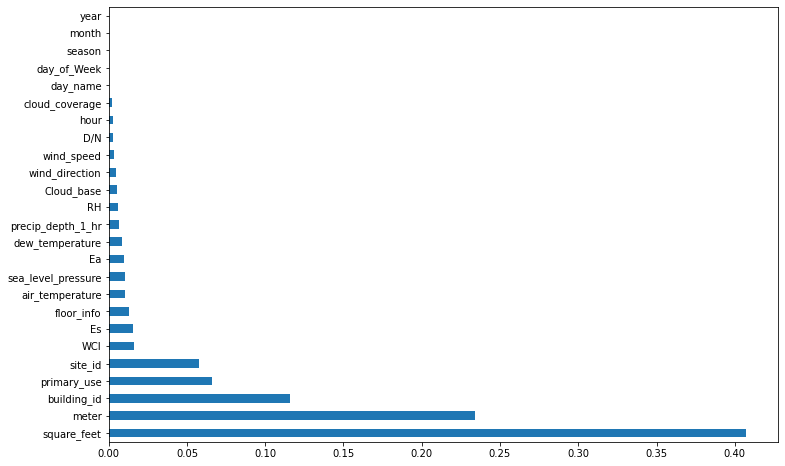

In [ ]:
X = X_train[:50000]
y = y_train[:50000]    
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

plt.figure(figsize=(12,8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

**Observations:**
* The feature **square_feet** seems like most importat feature. It is obvious because if the square_feet area is more, this indicates that the building size is large which eventually consumes more energy.
* Other features such as meter_types, primary_use,building_id, site_id, WCI and Es seems like relatively more important than rest of the features. 

#### **11.2 Shapley Values:**

SHAP is another method to study feature importance, which leverages Shapley values. In order to get feature importance of any feature, it first creates the subset of features by excluding that feature of which we are computing feature importance. It then predicts the target value with the subset of features and calculate the effect of that feature on the prediction by adding it to the subset of feature. By repeating this for all the features, feature importance of each feature is calculated. Positive shap values indicated that it pushes the prediction in positive direction whereas negative shap values pushes it in negative direction.
<br>*Reference*: https://www.mdpi.com/1996-1073/13/18/4870


In [ ]:
#pip install shap
import shap

In [ ]:
#Selecting fewer datapoints as this algorithm runs very slow on larger datasets.
datapoints = 500000

# Reference*: https://www.kaggle.com/prashant111/explain-your-model-predictions-with-shapley-values 
#XGBRegressor
xgb_model = XGBRegressor(n_estimators=5, max_depth=10, learning_rate=0.001, random_state=0, num_parallel_tree = 5)
xgb_model.fit(X_train[:datapoints], y_train[:datapoints])
y_predict = xgb_model.predict(X_train[datapoints:datapoints+500])

#Computing Shap Values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train[:datapoints])
#np.save('/content/drive/MyDrive/Case Study 01/Data/shap_values' ,shap_values)

##### **11.2.1 SHAP Summary Plot:**

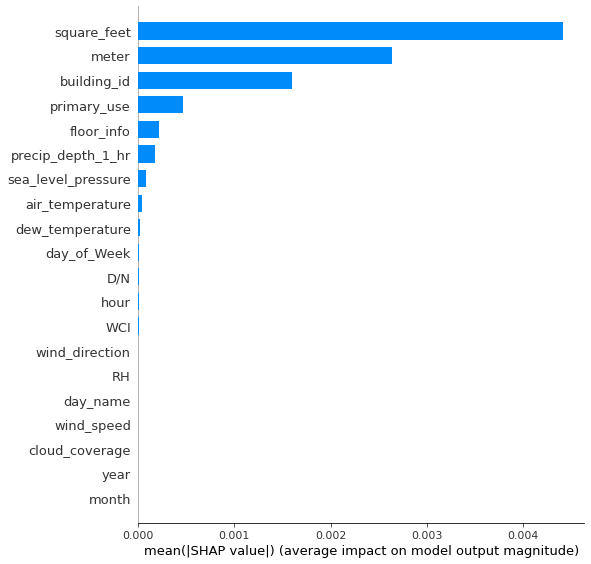

In [ ]:
shap.summary_plot(shap_values, X_train[:datapoints], plot_type="bar")

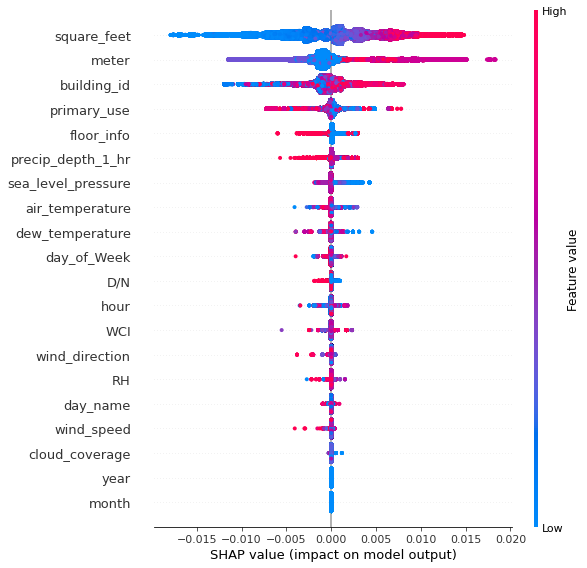

In [ ]:
#shap_values = np.load('/content/drive/MyDrive/Case Study 01/Data/shap_values.npy')
shap.summary_plot(shap_values, features=X_train[:datapoints], feature_names=X_train.columns)

**Observations:**
* The features are arranged on the y axis in descending order of their importance. So the `square_feet` is the most important feature amongst all others. Other features such as `meter`, `building_id` and `primary_use` also contribute significantly while predicting energy use.
* The low level of square_feet has a high and negative impact on energy prediction. The 'low' comes from blue color and negative impact can be seen from x-axis.
* Other features such as year, month which ranked at the bottom of the y-axis, also has shap values around zero indicates that these features doesn't contribute much in energy predictions and hence can be ignored. 

##### **11.2.2 SHAP Force Plot:**
 These plot shows each contributing to push the model output from the base value i.e. the average model output to the output. The features which pushes the predicted value on higher side than the mean value indicated by red color and those features which pushes it to lower values than the average indicated by blue color. These plots are plotted by single datapoints.

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 200 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)


**Observations:**
* For datapoint 200 , the average value is 0.5197 but the features building_id, primary_use and square_feet pushed the predicted value on higer side i.e. to 0.53.

In [ ]:
shap.initjs()
i = 50501
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

**Observations:**
* For datapoint 50551 , the average value is 0.5197 but the features square_feet, meter and floor_info pushed the predicted value on the lower side i.e. 0.51.

# **12. Preparing Test Data:**

Preparing Test Data to make it compatible with trained models:

#### **12.1 Test Dataset:**

In [ ]:
building_metadata = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/building_metadata.csv')
building_metadata = reduce_mem_usage(building_metadata)


weather_test = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/weather_test.csv')
weather_test = reduce_mem_usage(weather_test)

test_data = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/test.csv")
test_data = reduce_mem_usage(test_data)


Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%


#### **12.2 Train Data:**

In [ ]:
weather_train = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/weather_train.csv')
weather_train = reduce_mem_usage(weather_train)

train_data = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/train.csv')
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


#### **12.3 Defining Required Functions:**

#### **12.4 Processing Test Data**

In [ ]:
def processes_test_data(test_data:"Input Test data to be processed ", 
                        weather_test:"Input weather_test data", 
                        building_metadata:"building_metadata", 
                        train_data:"Processed Train Data - For Label Encoding and Scaling", 
                        data_scaling:"True if numerical scaling is needed"=False) -> "Returns Processed test data":
  '''
     1.This function accepts the raw test data and returns the processed data compatible for 
       Previously trained models.
     2.Also returns the site_id sequence info required for site_0 unit correction.
     '''

  # 1.Merging All Dataframes
  test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
  weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])
  test_data = test_data.merge(building_metadata, on='building_id', how='left', suffixes=None)
  test_data['timestamp'] = pd.to_datetime(test_data.timestamp.astype('object'))
  test_data = test_data.merge(weather_test, on=['site_id', 'timestamp'], how='left',  suffixes=None)

  # 2. Dropping unwanted features
  test_data = test_data.drop(['year_built'], axis=1)

  # 3 Adding floor_info feature
  floor_info = pd.DataFrame(test_data.floor_count.fillna(0))
  test_data['floor_info'] = floor_info
  test_data['floor_info'] = test_data.floor_info.apply(lambda x: 1 if x!=0 else 0)

  # 4.Weather Data
  #Converting timestamp-object type to datetime
  test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

  # 5.Extracting features from timestamps
  test_data['year'] = test_data['timestamp'].dt.year
  test_data['month'] = test_data['timestamp'].dt.month
  test_data['day_of_Week'] = test_data['timestamp'].dt.dayofweek
  test_data['day_name'] = test_data['timestamp'].dt.day_name()
  test_data['hour'] = test_data['timestamp'].dt.hour

  # 6. FE with weather data
  # 6.1 Adding New Feature - Season
  seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
  def season(month):
      for month_table in seasons.keys():
          if month in list(month_table):
              return seasons[month_table] 
  test_data['season'] = test_data.month.apply(season)

  # 6.2 Adding New Feature - Actual vapour pressure (Ea)
  test_data['Ea'] = 0.608 * np.exp((17.27*test_data.dew_temperature)/(test_data.dew_temperature+237.3))

  # 6.3 Adding New Feature - Mean saturation vapour pressure (Es)
  test_data['Es'] = 0.608 * np.exp((17.27*test_data.air_temperature)/(test_data.air_temperature+237.3))

  # 6.4 Adding New Feature - Relative Humidity:
  test_data['RH'] = np.round(((0.608 * np.exp((17.27*test_data.dew_temperature)/(test_data.dew_temperature+237.3)))/
                              (0.608 * np.exp((17.27*test_data.air_temperature)/(test_data.air_temperature+237.3))))*100,2)

  # 6.5 Adding New Feature - Cloud Base
  test_data['Cloud_base'] = (((((test_data.air_temperature*1.8)+32) - ((test_data.dew_temperature*1.8)+32))/4.4)*1000)*0.3048

  # 6.6 Adding New Feature - Windchill Index (WCI):
  test_data['WCI'] = WCI = np.round((13.12 + 0.6215 * test_data.air_temperature - 11.37*((test_data.wind_speed*2.235)**0.16) \
                    + 0.3965* test_data.air_temperature * ((test_data.wind_speed*2.235)**0.16)),2)

  # 6.7Adding New Feature - DAY/NIGHT Feature:
  day_hours = [i for i in range(6,19)]
  test_data['D/N'] = test_data.hour.apply(lambda x: 'Day' if x in day_hours else 'Night')


  # 7. Replacing Other Feature's missing values with their mean values
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
  numeric_columns = test_data.select_dtypes(include='number').columns
  test_data[numeric_columns] = pd.DataFrame(imputer.fit_transform(test_data[numeric_columns]), columns=numeric_columns)

  # 8. Encoding Categorical Data
  encoder = LabelEncoder()
  categorical_columns = train_data.select_dtypes(include=['category', 'object']).columns.tolist()
  for features in categorical_columns:
    if features not in ['timestamp']:
      train_data[features] = encoder.fit_transform(train_data[features])
      test_data[features] = encoder.transform(test_data[features])

  # 9. Preserving site_id's and meter types required from site_0 meter readings unit corrections
  site_id_test_list = test_data.site_id
  meter_type_test_list = test_data.meter

  # 10. Numerical Data Scaling for linear models
  if data_scaling:
    numeric_columns = train_data.select_dtypes(include='number').columns.tolist()
    scaler = MinMaxScaler()
    for features in numeric_columns:
      if features not in ['timestamp','meter_reading', 'meter_reading_corrected', 'meter_reading_transformed', 'floor_count']:
        train_data[features] = scaler.fit_transform(train_data[features].values.reshape(-1,1))
        test_data[features] = scaler.transform(test_data[features].values.reshape(-1,1))

  # 11. Rearrange features as per train data
  test_data_processed = test_data[['building_id','meter','site_id','primary_use','square_feet','floor_info','air_temperature','cloud_coverage',
    'dew_temperature','precip_depth_1_hr','sea_level_pressure', 'wind_direction','wind_speed','year','month',
    'day_of_Week','day_name','hour','season','Ea','Es','RH','Cloud_base','WCI','D/N']]

  return test_data_processed, site_id_test_list, meter_type_test_list



##### **12.4.1 Test Data - unscaled.**

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Study 01/Data/test_data_processed.csv'):
  test_data, site_id_info_test, meter_type_info_test = processes_test_data(test_data, weather_test, building_metadata,
                                                       train_data,data_scaling=False )
  #saving on disk
  test_data.to_csv("/content/drive/MyDrive/Case Study 01/Data/test_data_processed.csv")
  site_id_info_test.to_csv("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.csv")
  meter_type_info_test.to_csv("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.csv")

else:
  #Loading data from the disk
  test_data = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/test_data_processed.csv")
  site_id_info_test = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.csv")
  meter_type_info_test = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.csv")
  test_data = reduce_mem_usage(test_data)
  if 'Unnamed: 0' in test_data.columns.tolist():
    test_data = test_data.drop(['Unnamed: 0'], axis=1)
  if 'Unnamed: 0' in site_id_info_test.columns.tolist():
    site_id_info_test = site_id_info_test.drop(['Unnamed: 0'], axis=1)    

Memory usage of dataframe is 8271.31 MB
Memory usage after optimization is: 2107.59 MB
Decreased by 74.5%


**Saving Data in Feather Format for Sapce Optimization**

In [ ]:
test_data.to_feather("/content/drive/MyDrive/Case Study 01/Data/test_data_processed.ftr")
site_id_info_test.to_feather("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.ftr")
meter_type_info_test.to_feather("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.ftr")

##### **12.4.2 Test Data- Scaled**


**preprocessing_data** ( ........ , data_scaling = **True**`) 

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Study 01/Data/test_data_processed_scaled.csv'):
  test_data_scaled, site_id_info_test, meter_type_info_test = processes_test_data(test_data, weather_test, building_metadata,
                                                              train_data,data_scaling=True)
  #saving on disk
  test_data_scaled.to_csv("/content/drive/MyDrive/Case Study 01/Data/test_data_processed_scaled.csv")
  site_id_info_test.to_csv("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.csv")
  meter_type_info_test.to_csv("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.csv")

else:
  #Loading data from the disk
  test_data_scaled = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/test_data_processed_scaled.csv")
  site_id_info_test = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.csv")
  meter_type_info_test = pd.read_csv("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.csv")
  test_data_scaled = reduce_mem_usage(test_data_scaled)
  if 'Unnamed: 0' in test_data_scaled.columns.tolist():
    test_data_scaled = test_data_scaled.drop(['Unnamed: 0'], axis=1)
  if 'Unnamed: 0' in site_id_info_test.columns.tolist():
    site_id_info_test = site_id_info_test.drop(['Unnamed: 0'], axis=1)  

Memory usage of dataframe is 8271.31 MB
Memory usage after optimization is: 2147.36 MB
Decreased by 74.0%


**Saving Data in Feather Format for Sapce Optimization**

In [ ]:
test_data_scaled.to_feather("/content/drive/MyDrive/Case Study 01/Data/test_data_processed_scaled.ftr")
site_id_info_test.to_feather("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.ftr")
meter_type_info_test.to_feather("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.ftr")

#### **12.5 Target Inverse Transformation**

* As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
* For site_0 meter readings, we have converted the origional unites from to kBTU to KW. So before submission, need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118. 

In [ ]:
def target_transf(site_id_info: "site_ids from the given data ",
                  meter_type_info:"meter types of each datapoint",
                  predicted_op: "predicted outputs from the model") -> "Returns Transfoemed Output":
  '''
  1.As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
  2.For site_0 Electrical Meter readings, we have converted the origional unites from to kBTU to KW. So before submission,
  need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118.
  '''

  # Target Transformation
  pred_df = site_id_info_test.copy()
  pred_df['meter'] = meter_type_info_test
  pred_df['test_pred'] = np.expm1(predicted_op)

  # Unit Conversion for site_0
  pred_df['test_pred']= np.where(np.logical_and(pred_df['site_id'] == 0, pred_df['meter'] == 0),
                                  pred_df['test_pred'] * 3.4118,
                                  pred_df['test_pred'])

  # Dropping site_id feature
  pred_df = pred_df.drop(['site_id', 'meter'], axis=1)
    
  # Adding row_id features are shown in sample_submission file
  pred_df = pred_df.reset_index()
  pred_df.columns = ['row_id', 'meter_reading']

  return pred_df

`CONTD PART B: MODELING..`